<b>General remark:</b> Leverage the code provided in lecture notes as much as you can/want. Please motivate your choices and discuss the results for each question below.
# 1   Logistic Regression

Consider the [Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) Dataset that was studied and extensively discussed in
the lectures.

(a) <b>Data preprocessing:</b>
- Provide a proposal on how to improve data preprocessing relative to the procedure described in the lecture notes. Consider possible different and/or additional transformations of features and treatment of outliers.  
Remark: Focus on a couple of approaches that make most sense to you. This exercise serves rather as a test of the impact of further data preprocessing than as a quest for the best possible procedure. However, please put an effort in thinking about reasonable data transformations that could potentially improve
the predictive power of your model(s).
- Evaluate the impact of the proposed data treatment algorithms on the performance of the logistic-regression-based classification method using the scaled
training and testing data. Select the relevant performance metrics from those available in scikit-learn. For this exercise you do not have to generate any
charts—it is sufficient to tabulate your results.

### Dataset Information

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. There are 25 features in the dataset. They are as follows:

1. `ID:` Identification of each credit card client

2. `LIMIT_BAL:` The maximum amount or credit (in NT dollar) a client can spend in a month (includes individual and family/supplementary credit)

3. `SEX`: Gender of a client where `1` denotes male client and `2` denotes a female client

4. `EDUCATION`: Education qualification of a credit card holder: 

      - `1` denotes that a client graduated from a graduate school 

      - `2` denotes that a client is a university graduate

      - `3` denotes that a client is a high school graduate

      - `4` denotes that a client graduated from some other institution

      - `5` denotes that the graduation status of a client is unknown

5. `MARRIAGE`: Marital status of a client:
    
      - `1` denotes that the client is married 
      
      - `2` denotes that the client is single or unmarried 
      
      - `3` covers all the other possibilities of marital status such as divorced, widowed etc

6. `AGE`: Age of a client in years

7. `PAY_0`: Repayment status of a client in September 2005
      
      - `-2` denotes the there is no consumption 
      
      - `-1` denotes the payment is not due 
      
      - `0` denotes the revolving payment 

      - `1` denotes that the payment is delayed by one month

      - `2` denotes that the payment is delayed by two months

        ...

      - `8` denotes that the payment is delayed by eight months 

      - `9` denotes that the payment is delayed by nine months and above

8. `PAY_2`: Repayment status of a client in August 2005 (scale same as above)

9. `PAY_3`: Repayment status of a client in July 2005 (scale same as above)

10. `PAY_4`: Repayment status of a client in June 2005 (scale same as above)

11. `PAY_5`: Repayment status of a client in May 2005 (scale same as above)

12. `PAY_6`: Repayment status of a client in April 2005 (scale same as above)

13. `BILL_AMT1`: Amount of bill statement in September 2005 (NT dollar)

14. `BILL_AMT2`: Amount of bill statement in August 2005 (NT dollar)

15. `BILL_AMT3`: Amount of bill statement in July 2005 (NT dollar)

16. `BILL_AMT4`: Amount of bill statement in June 2005 (NT dollar)

17. `BILL_AMT5`: Amount of bill statement in May 2005 (NT dollar)

18. `BILL_AMT6`: Amount of bill statement in April 2005 (NT dollar)

19. `PAY_AMT1`: Amount of previous payment in September 2005 (NT dollar)

20. `PAY_AMT2`: Amount of previous payment in August 2005 (NT dollar)

21. `PAY_AMT3`: Amount of previous payment in July 2005 (NT dollar)

22. `PAY_AMT4`: Amount of previous payment in June 2005 (NT dollar)

23. `PAY_AMT5`: Amount of previous payment in May 2005 (NT dollar)

24. `PAY_AMT6`: Amount of previous payment in April 2005 (NT dollar)

25. `default.payment.next.month`: The default payment status of a client in the following month (October) where 

      - `1` means `yes` the client is a defaulter i.e., they failed to make the payment due in the following month

      - `0` means `no` the client is NOT a defaulter i.e., they successfully made the payment due in the following month

Aditional informations about PAY_0 variable ( for -2 and 0 values ):
http://inseaddataanalytics.github.io/INSEADAnalytics/CourseSessions/ClassificationProcessCreditCardDefault.html



In [ ]:
# Import / install relevant Python packages
import numpy as np
from numpy import where
import pandas as pd
from pandas import set_option
import datetime as dt
import statsmodels.api as sm
from scipy.stats import (randint, loguniform)

from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.datasets import make_multilabel_classification

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (RFE, SelectFromModel)
from sklearn.model_selection import (KFold, GridSearchCV, RandomizedSearchCV, cross_val_score)
from sklearn import metrics
from sklearn.metrics import (classification_report, confusion_matrix)
from sklearn.svm import (SVC, LinearSVC)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (DecisionTreeClassifier, plot_tree)
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
import seaborn as sns

In [ ]:
# Import data and print a sample
df_ccd = pd.read_csv('UCI_Credit_Card.csv')
df_ccd.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
1979,1980,500000.0,2,1,1,35,0,0,0,0,...,48322.0,21593.0,13866.0,2504.0,10004.0,5178.0,1047.0,2019.0,1004.0,1
13935,13936,200000.0,2,3,1,42,2,0,0,0,...,141141.0,144216.0,144027.0,8064.0,9474.0,4944.0,5240.0,5214.0,10314.0,0
18834,18835,20000.0,2,3,1,24,-1,-1,-2,-1,...,749.0,0.0,0.0,0.0,0.0,823.0,0.0,0.0,519.0,0
7682,7683,240000.0,1,3,1,48,0,0,0,0,...,131864.0,134744.0,138504.0,15000.0,6000.0,5000.0,5000.0,6000.0,6000.0,0
28482,28483,50000.0,2,2,2,44,-1,-1,-1,-1,...,827.0,105.0,270.0,1463.0,1276.0,827.0,105.0,270.0,573.0,0


In [ ]:
# EDA: Edit the name of the last variable and drop the column ID
df_ccd.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)
df_ccd.drop('ID', axis = 1, inplace =True) 
df_ccd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

<font color='Green'><left><b>
Gender check
</b></left></font>

In [ ]:
# EDA: Print unique values for selected features
print('Gender (1 = male; 2 = female):')
print(sorted(df_ccd['SEX'].unique()))

Gender (1 = male; 2 = female):
[1, 2]


<font color='Green'><left><b>
Gender check - OK
</b></left></font>

In [ ]:
print('Education (1 = graduate school; 2 = university; 3 = high school; 4 = others; 5 = some other institution; 6 =  unknown):')
print(sorted(df_ccd['EDUCATION'].unique()))
len(df_ccd[df_ccd['EDUCATION']==0])

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others; 5 = some other institution; 6 =  unknown):
[0, 1, 2, 3, 4, 5, 6]


14

## <font color='Green'><left><b>
As education 0 value is not determined and it is only 14 observation in total, we will corect it to be 6 ( unknown ). 
</b></left></font>

In [ ]:
df_ccd['EDUCATION']=np.where(df_ccd['EDUCATION'] == 0, 6, df_ccd['EDUCATION'])

<font color='Green'><left><b>
Marital status check
</b></left></font>

In [ ]:
print('Marital status (1 = married; 2 = single; 3 = others):')
print(sorted(df_ccd['MARRIAGE'].unique()))
len(df_ccd[df_ccd['MARRIAGE']==0])

Marital status (1 = married; 2 = single; 3 = others):
[0, 1, 2, 3]


54

<font color='Green'><left><b>
As marital 0 value is not determined and has only 54 observation on total, we will corect it to be 3 ( others ). 
</b></left></font>

In [ ]:
df_ccd['MARRIAGE']=np.where(df_ccd['MARRIAGE'] == 0, 3, df_ccd['MARRIAGE'])

<font color='Green'><left><b>
Repayment status, Amount of bill statement and Amount of previous payment relation check. 

If there is no debt ( bill - previous payment >=0 ) Repayment status should be <= 0. If debt is grater than 0 than Repayment status should be grater than 0 ( months of delay ) or equal to 0 ( revolving ).
</b></left></font>

In [ ]:
print('Payment status (-2 = no consumption;-1 = pay duly;0 = revolving payment; K = payment delay for K months, for K=1,2,...,8; 9 = payment delay for nine months and above):')
print(sorted(df_ccd['PAY_0'].unique()))
print(sorted(df_ccd['PAY_2'].unique()))
print(sorted(df_ccd['PAY_3'].unique()))
print(sorted(df_ccd['PAY_4'].unique()))
print(sorted(df_ccd['PAY_5'].unique()))
print(sorted(df_ccd['PAY_6'].unique()))

Payment status (-2 = no consumption;-1 = pay duly;0 = revolving payment; K = payment delay for K months, for K=1,2,...,8; 9 = payment delay for nine months and above):
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
# No error for observations If status is "No consumption" or "pay duly" (PAY_2 < 0) then BILL_AMT2 - PAY_AMT1 <= 0 should be less or equal then 0 
PAY_2_good_no_error = ((df_ccd['PAY_2'] < 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] <= 0 ) == True).sum()
PAY_3_good_no_error = ((df_ccd['PAY_3'] < 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] <= 0 ) == True).sum()
PAY_4_good_no_error = ((df_ccd['PAY_4'] < 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] <= 0 ) == True).sum()
PAY_5_good_no_error = ((df_ccd['PAY_5'] < 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] <= 0 ) == True).sum()
PAY_6_good_no_error = ((df_ccd['PAY_6'] < 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] <= 0 ) == True).sum()
PAY_good_no_error = PAY_2_good_no_error + PAY_3_good_no_error + PAY_4_good_no_error + PAY_5_good_no_error + PAY_6_good_no_error

In [ ]:
# Error for observations If status is "No consumption" or "pay duly" (PAY_2 < 0) then BILL_AMT2 - PAY_AMT1 > 0 should be greater then 0 
PAY_2_good_error =(((df_ccd['PAY_2'] < 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] <= 0 ) == False) & (df_ccd['PAY_2'] < 0 )).sum()
PAY_3_good_error =(((df_ccd['PAY_3'] < 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] <= 0 ) == False) & (df_ccd['PAY_3'] < 0 )).sum()
PAY_4_good_error =(((df_ccd['PAY_4'] < 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] <= 0 ) == False) & (df_ccd['PAY_4'] < 0 )).sum()
PAY_5_good_error = (((df_ccd['PAY_5'] < 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] <= 0 ) == False) & (df_ccd['PAY_5'] < 0 )).sum()
PAY_6_good_error = (((df_ccd['PAY_6'] < 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] <= 0 ) == False) & (df_ccd['PAY_6'] < 0 )).sum()
PAY_good_error = PAY_2_good_error + PAY_3_good_error + PAY_4_good_error + PAY_5_good_error + PAY_6_good_error

In [ ]:
# No error for observations If status is "payment delay" (PAY_2 > 0) then BILL_AMT2 - PAY_AMT1 > 0 should be greater then 0 
PAY_2_bad_no_error = ((df_ccd['PAY_2'] > 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] > 0 ) == True).sum()
PAY_3_bad_no_error = ((df_ccd['PAY_3'] > 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] > 0 ) == True).sum()
PAY_4_bad_no_error = ((df_ccd['PAY_4'] > 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] > 0 ) == True).sum()
PAY_5_bad_no_error = ((df_ccd['PAY_5'] > 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] > 0 ) == True).sum()
PAY_6_bad_no_error = ((df_ccd['PAY_6'] > 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] > 0 ) == True).sum()
PAY_bad_no_error = PAY_2_bad_no_error + PAY_3_bad_no_error + PAY_4_bad_no_error + PAY_5_bad_no_error + PAY_6_bad_no_error

In [ ]:
# Error for observations If status is "payment delay" (PAY_2 > 0) then BILL_AMT2 - PAY_AMT1 <= 0 should be less or equal then 0
PAY_2_bad_error =(((df_ccd['PAY_2'] > 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] > 0 ) == False) & (df_ccd['PAY_2'] > 0 )).sum()
PAY_3_bad_error =(((df_ccd['PAY_3'] > 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] > 0 ) == False) & (df_ccd['PAY_3'] > 0 )).sum()
PAY_4_bad_error =(((df_ccd['PAY_4'] > 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] > 0 ) == False) & (df_ccd['PAY_4'] > 0 )).sum()
PAY_5_bad_error = (((df_ccd['PAY_5'] > 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] > 0 ) == False) & (df_ccd['PAY_5'] > 0 )).sum()
PAY_6_bad_error = (((df_ccd['PAY_6'] > 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] > 0 ) == False) & (df_ccd['PAY_6'] > 0 )).sum()
PAY_bad_error = PAY_2_bad_error + PAY_3_bad_error + PAY_4_bad_error + PAY_5_bad_error + PAY_6_bad_error

In [ ]:
# No error for observations If status is "revolving" (PAY_2 = 0) then BILL_AMT2 - PAY_AMT1 >= 0 should be greater or equal then 0 
PAY_2_revolving_no_error = ((df_ccd['PAY_2'] == 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] >= 0 ) == True).sum()
PAY_3_revolving_no_error = ((df_ccd['PAY_3'] == 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] >= 0 ) == True).sum()
PAY_4_revolving_no_error = ((df_ccd['PAY_4'] == 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] >= 0 ) == True).sum()
PAY_5_revolving_no_error = ((df_ccd['PAY_5'] == 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] >= 0 ) == True).sum()
PAY_6_revolving_no_error = ((df_ccd['PAY_6'] == 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] >= 0 ) == True).sum()
PAY_revolving_no_error = PAY_2_revolving_no_error + PAY_3_revolving_no_error + PAY_4_revolving_no_error + PAY_5_revolving_no_error + PAY_6_revolving_no_error

In [ ]:
# Error for observations If status is "revolving" (PAY_2 = 0) then BILL_AMT2 - PAY_AMT1 <= 0 should < 0 should be less then 0 
PAY_2_revolving_error =(((df_ccd['PAY_2'] == 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] >= 0 ) == False) & (df_ccd['PAY_2'] == 0 )).sum()
PAY_3_revolving_error =(((df_ccd['PAY_3'] == 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] >= 0 ) == False) & (df_ccd['PAY_3'] == 0 )).sum()
PAY_4_revolving_error =(((df_ccd['PAY_4'] == 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] >= 0 ) == False) & (df_ccd['PAY_4'] == 0 )).sum()
PAY_5_revolving_error = (((df_ccd['PAY_5'] == 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] >= 0 ) == False) & (df_ccd['PAY_5'] == 0 )).sum()
PAY_6_revolving_error = (((df_ccd['PAY_6'] == 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] >= 0 ) == False) & (df_ccd['PAY_6'] == 0 )).sum()
PAY_revolving_error = PAY_2_revolving_error + PAY_3_revolving_error + PAY_4_revolving_error + PAY_5_revolving_error + PAY_6_revolving_error

In [ ]:
PAY_error = PAY_good_error+PAY_bad_error+PAY_revolving_error
PAY_no_error = PAY_good_no_error+PAY_bad_no_error+PAY_revolving_no_error
PAY=PAY_error+PAY_no_error

In [ ]:
print('Error for observations If status is Pay duly (or No consumption),  Payment delay,  Revolving, Sum')
print(PAY_good_error,PAY_bad_error,PAY_revolving_error,PAY_error)
print('No Error for observations If status is pay duly (or No consumption),payment delay,revolving, Sum')
print(PAY_good_no_error,PAY_bad_no_error,PAY_revolving_no_error,PAY_no_error)
print('Error for observations If status is Pay duly(or No consumption),  Payment delay,  Revolving, Sum in %')
print(PAY_good_error/(PAY_good_error+PAY_good_no_error),PAY_bad_error/(PAY_bad_error+PAY_bad_no_error),PAY_revolving_error/(PAY_revolving_error+PAY_revolving_no_error),PAY_error/(PAY_error+PAY_no_error))

Error for observations If status is Pay duly(or No consumption),  Payment delay,  Revolving, Sum
949 422 555 1926
No Error for observations If status is pay duly(or No consumption),payment delay,revolving, Sum
49661 17786 80627 148074
Error for observations If status is Pay duly(or No consumption),  Payment delay,  Revolving, Sum in %
0.018751234933807547 0.023176625659050966 0.006836490847724865 0.01284


In [ ]:
PAY/5

30000.0

<font color='Green'><left><b>
If we assume that "good" client (the one that pays bills on time - "Payment delay" status less than 0 ) doesn't have debt, and that "bad" client (the one with payment delay) can not pay its debt, we sholud make this correction ( 949+422 = 1371 out of 150000 ). 
</b></left></font>

In [ ]:
# EDA: Correct the data for the variable PAY_K - if status is "No consumption" or "pay duly" (PAY_2 < 0) then BILL_AMT2 - PAY_AMT1 > 0 is not possible.
#It should be delay in payment or revolving.
df_ccd['PAY_2']=np.where(((df_ccd['PAY_2'] < 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] <= 0 ) == False) & (df_ccd['PAY_2'] < 0 ), 1, df_ccd['PAY_2'])
df_ccd['PAY_3']=np.where(((df_ccd['PAY_3'] < 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] <= 0 ) == False) & (df_ccd['PAY_3'] < 0 ), 1, df_ccd['PAY_3'])
df_ccd['PAY_4']=np.where(((df_ccd['PAY_4'] < 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] <= 0 ) == False) & (df_ccd['PAY_4'] < 0 ), 1, df_ccd['PAY_4'])
df_ccd['PAY_5']=np.where(((df_ccd['PAY_5'] < 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] <= 0 ) == False) & (df_ccd['PAY_5'] < 0 ), 1, df_ccd['PAY_5'])
df_ccd['PAY_6']=np.where(((df_ccd['PAY_6'] < 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] <= 0 ) == False) & (df_ccd['PAY_6'] < 0 ), 1, df_ccd['PAY_6'])

In [ ]:
# EDA: Correct the data for the variable PAY_K - If status is "payment delay" (PAY_2 > 0) then BILL_AMT2 - PAY_AMT1 <= 0 is not possible.
#It should be "No consumption" or "pay duly".
df_ccd['PAY_2']=np.where(((df_ccd['PAY_2'] > 0 ) & (df_ccd['BILL_AMT2'] - df_ccd['PAY_AMT1'] > 0 ) == False) & (df_ccd['PAY_2'] > 0 ), -1, df_ccd['PAY_2'])
df_ccd['PAY_3']=np.where(((df_ccd['PAY_3'] > 0 ) & (df_ccd['BILL_AMT3'] - df_ccd['PAY_AMT2'] > 0 ) == False) & (df_ccd['PAY_3'] > 0 ), -1, df_ccd['PAY_3'])
df_ccd['PAY_4']=np.where(((df_ccd['PAY_4'] > 0 ) & (df_ccd['BILL_AMT4'] - df_ccd['PAY_AMT3'] > 0 ) == False) & (df_ccd['PAY_4'] > 0 ), -1, df_ccd['PAY_4'])
df_ccd['PAY_5']=np.where(((df_ccd['PAY_5'] > 0 ) & (df_ccd['BILL_AMT5'] - df_ccd['PAY_AMT4'] > 0 ) == False) & (df_ccd['PAY_5'] > 0 ), -1, df_ccd['PAY_5'])
df_ccd['PAY_6']=np.where(((df_ccd['PAY_6'] > 0 ) & (df_ccd['BILL_AMT6'] - df_ccd['PAY_AMT5'] > 0 ) == False) & (df_ccd['PAY_6'] > 0 ), -1, df_ccd['PAY_6'])

<font color='Green'><left><b>
During the analysis of relation among Repayment status, Amount of bill statement and Amount of previous payment, we could notice that Repayment status for payment delay is not conisnstetly determined, so we will agregate payment delay for PAY_2 and above. 
</b></left></font>

In [ ]:
# EDA: Correct the data for the variable PAY_K where K >= 2. - Agregate to value 1.
df_ccd['PAY_2']=np.where(df_ccd['PAY_2'] > 1 , 1, df_ccd['PAY_2'])
df_ccd['PAY_3']=np.where(df_ccd['PAY_3'] > 1 , 1, df_ccd['PAY_3'])
df_ccd['PAY_4']=np.where(df_ccd['PAY_4'] > 1 , 1, df_ccd['PAY_4'])
df_ccd['PAY_5']=np.where(df_ccd['PAY_5'] > 1 , 1, df_ccd['PAY_5'])
df_ccd['PAY_6']=np.where(df_ccd['PAY_6'] > 1 , 1, df_ccd['PAY_6'])

<font color='Green'><left><b>
Data corection done.
</b></left></font>

In [ ]:
# EDA: Define features and target variable
X = df_ccd.drop('DEFAULT', axis = 1, inplace = False)
y = df_ccd['DEFAULT']

In [ ]:
# EDA: Target variable (credit card defaults)
n_total_count       = len(y)
n_default_count     = y.sum()
n_non_default_count = n_total_count - n_default_count
n_default_pct       = round(100 * n_default_count / n_total_count, 1)
n_non_default_pct   = round(100 * n_non_default_count / n_total_count, 1)

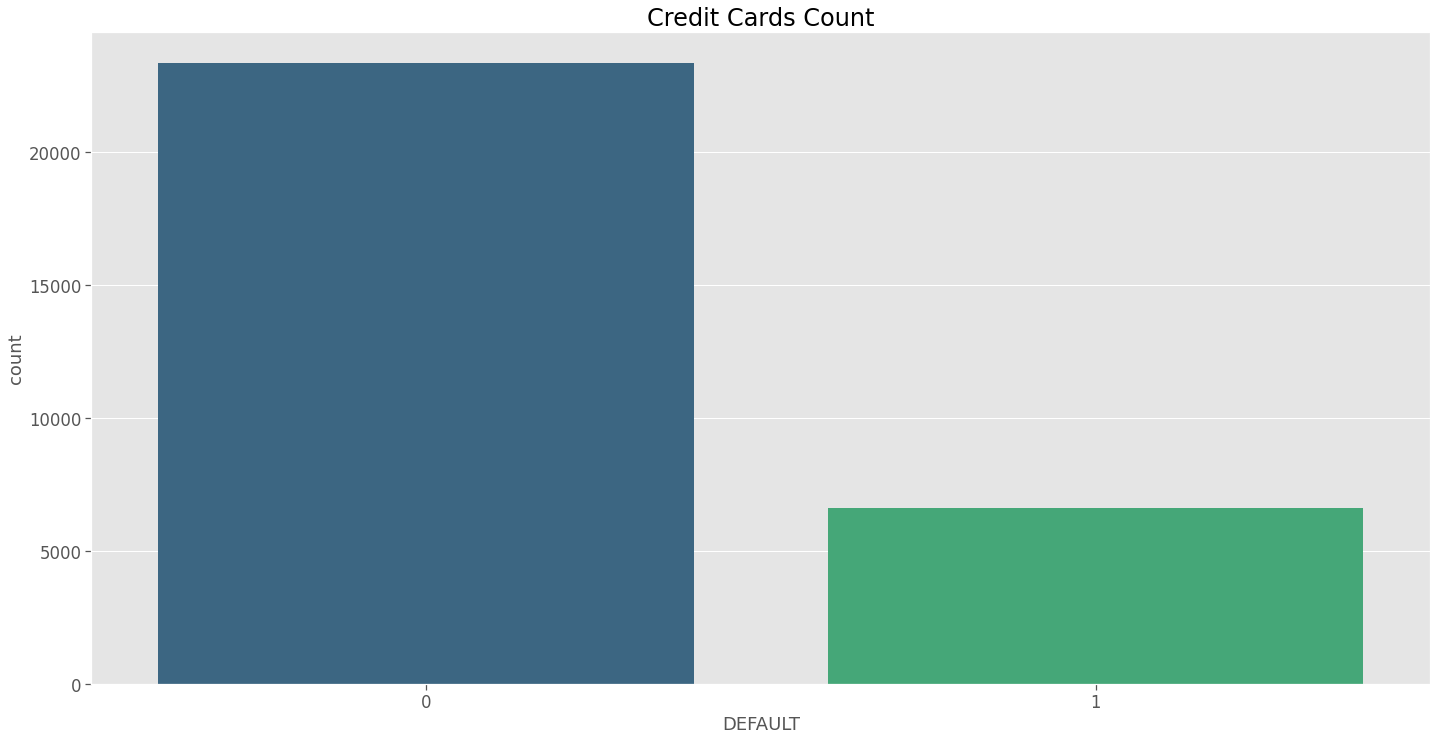

In [ ]:
# EDA: Plot count of defaults and non-defaults on credit cards
plt.figure(figsize=(24,12))

sns.set_context('notebook', font_scale=1.5)

sns.countplot(x='DEFAULT', data=df_ccd, palette='viridis')
plt.title('Credit Cards Count', size=24)

#plt.annotate('Default: {}'.format(n_default_count), xycoords = 'subfigure fraction', xy=(0.71, 0.15), xytext=(0.71, 0.15), size=20)
#plt.annotate('Non-default: {}'.format(n_non_default_count), xycoords = 'subfigure fraction', xy=(0.23, 0.15), xytext=(0.23, 0.15), size=20)
#plt.annotate(str(n_default_pct)+' %', xycoords = 'subfigure fraction', xy=(0.74, 0.20), xytext=(0.74, 0.20), size=20)
#plt.annotate(str(n_non_default_pct)+' %', xycoords = 'subfigure fraction', xy=(0.28, 0.20), xytext=(0.28, 0.20), size=20)

plt.show()

In [ ]:
# EDA: Display descriptive statistics
set_option('precision', 2)
set_option('display.width', 100)

print('Descriptive statistics:')
df_ccd.describe().T

Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1.00e+06
SEX,30000.0,1.60,0.49,1.0,1.00,2.0,2.00,2.00e+00
EDUCATION,30000.0,1.86,0.79,1.0,1.00,2.0,2.00,6.00e+00
MARRIAGE,30000.0,1.56,0.52,1.0,1.00,2.0,2.00,3.00e+00
AGE,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,7.90e+01
PAY_0,30000.0,-0.02,1.12,-2.0,-1.00,0.0,0.00,8.00e+00
PAY_2,30000.0,-0.29,0.87,-2.0,-1.00,0.0,0.00,1.00e+00
PAY_3,30000.0,-0.33,0.88,-2.0,-1.00,0.0,0.00,1.00e+00
PAY_4,30000.0,-0.36,0.87,-2.0,-1.00,0.0,0.00,1.00e+00
PAY_5,30000.0,-0.38,0.86,-2.0,-1.00,0.0,0.00,1.00e+00


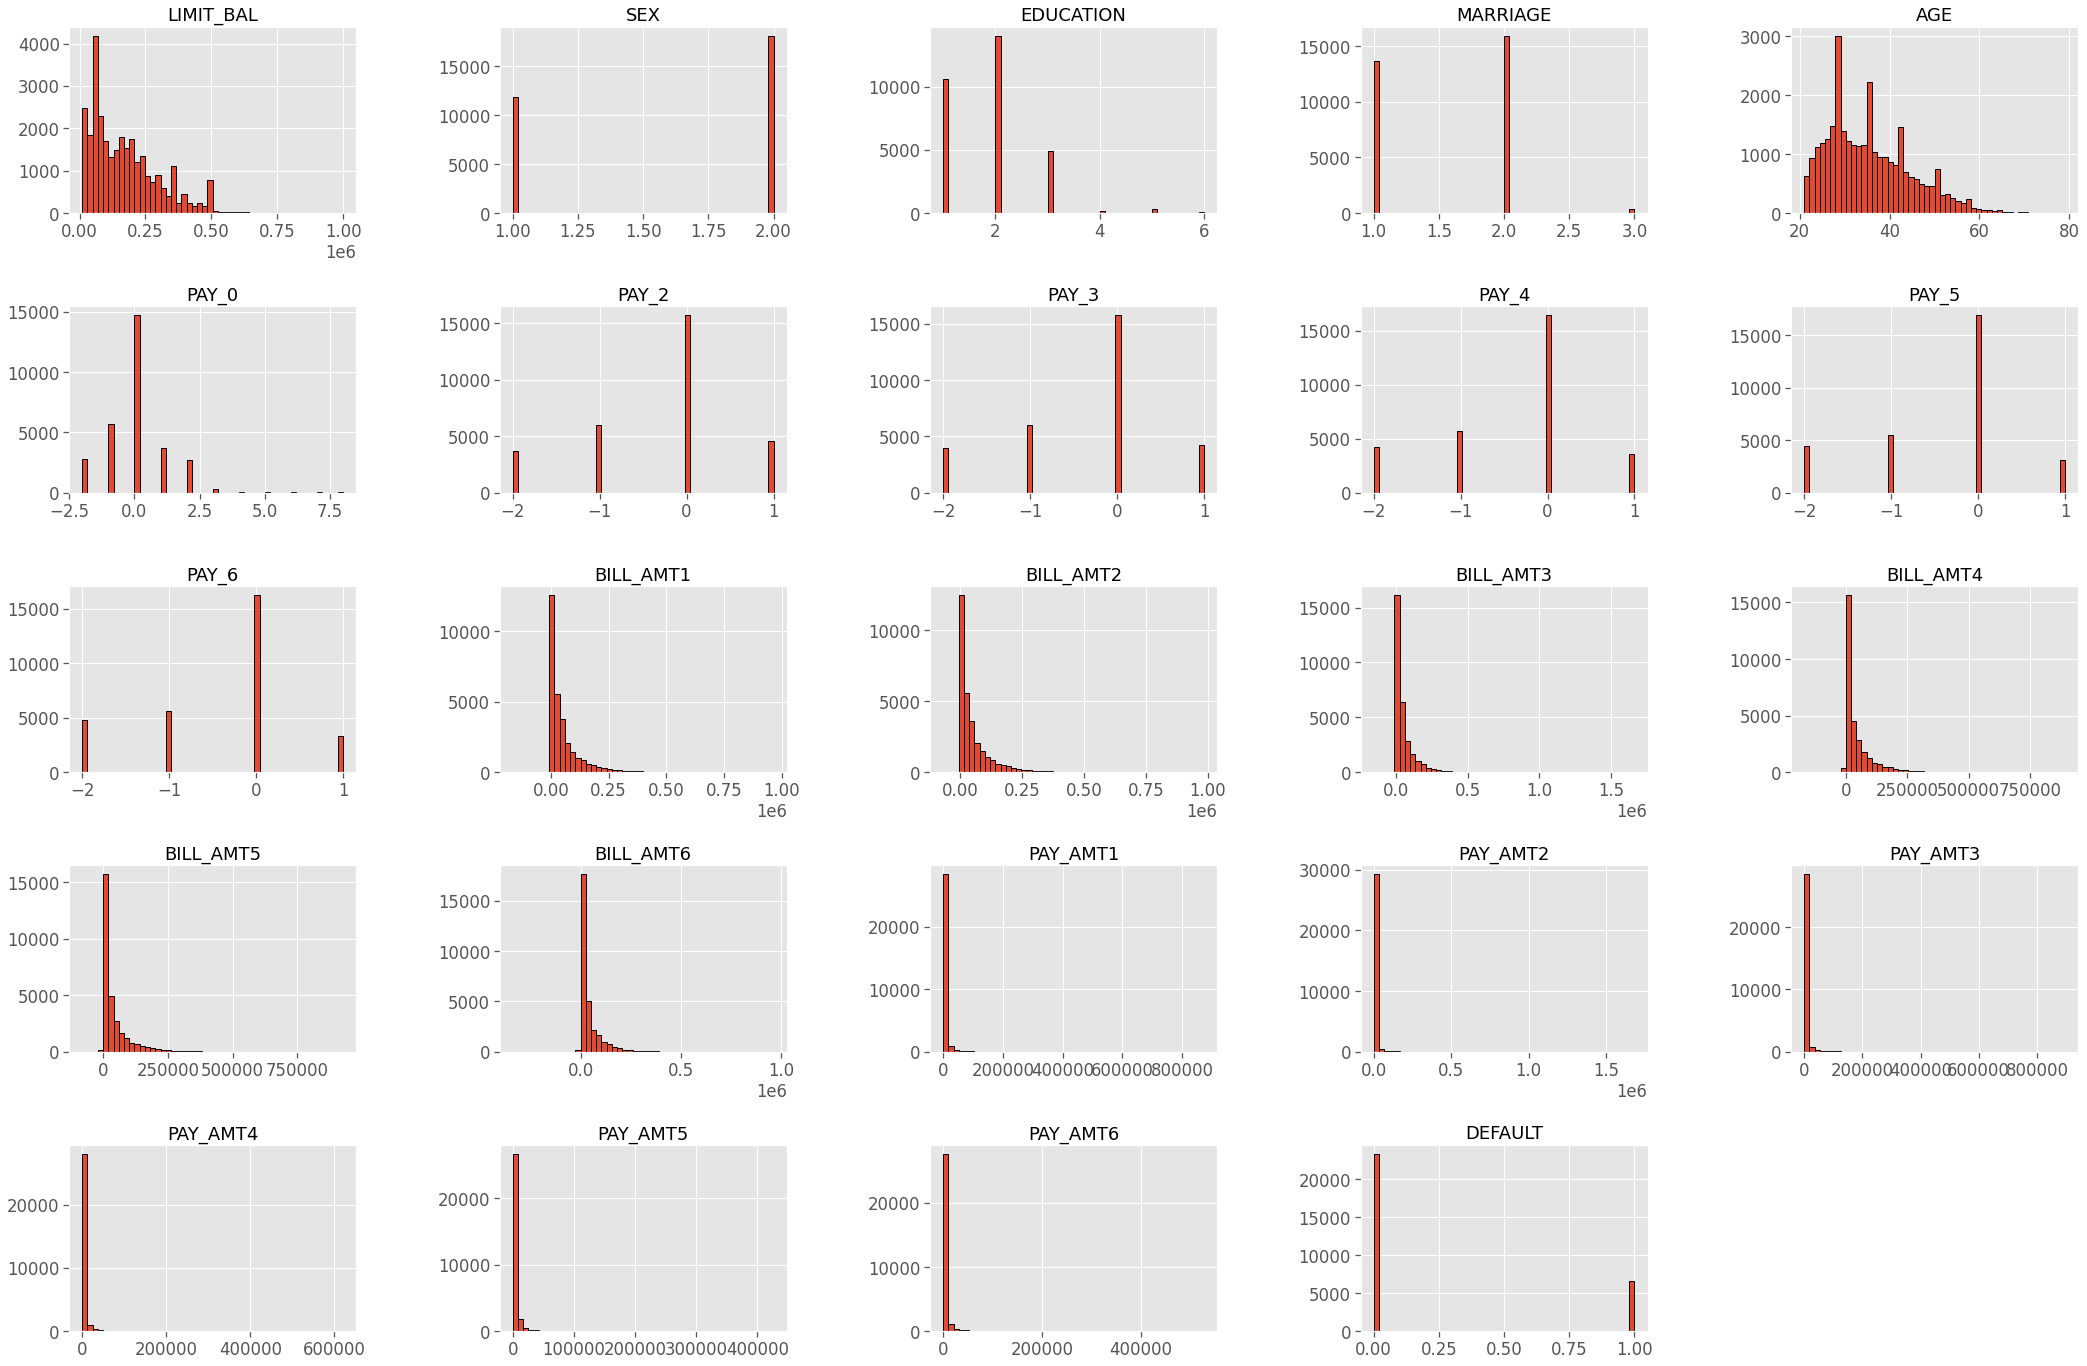

In [ ]:
# EDA: Plot histograms for all variables (features + target)
df_ccd.hist(figsize=(36, 24), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

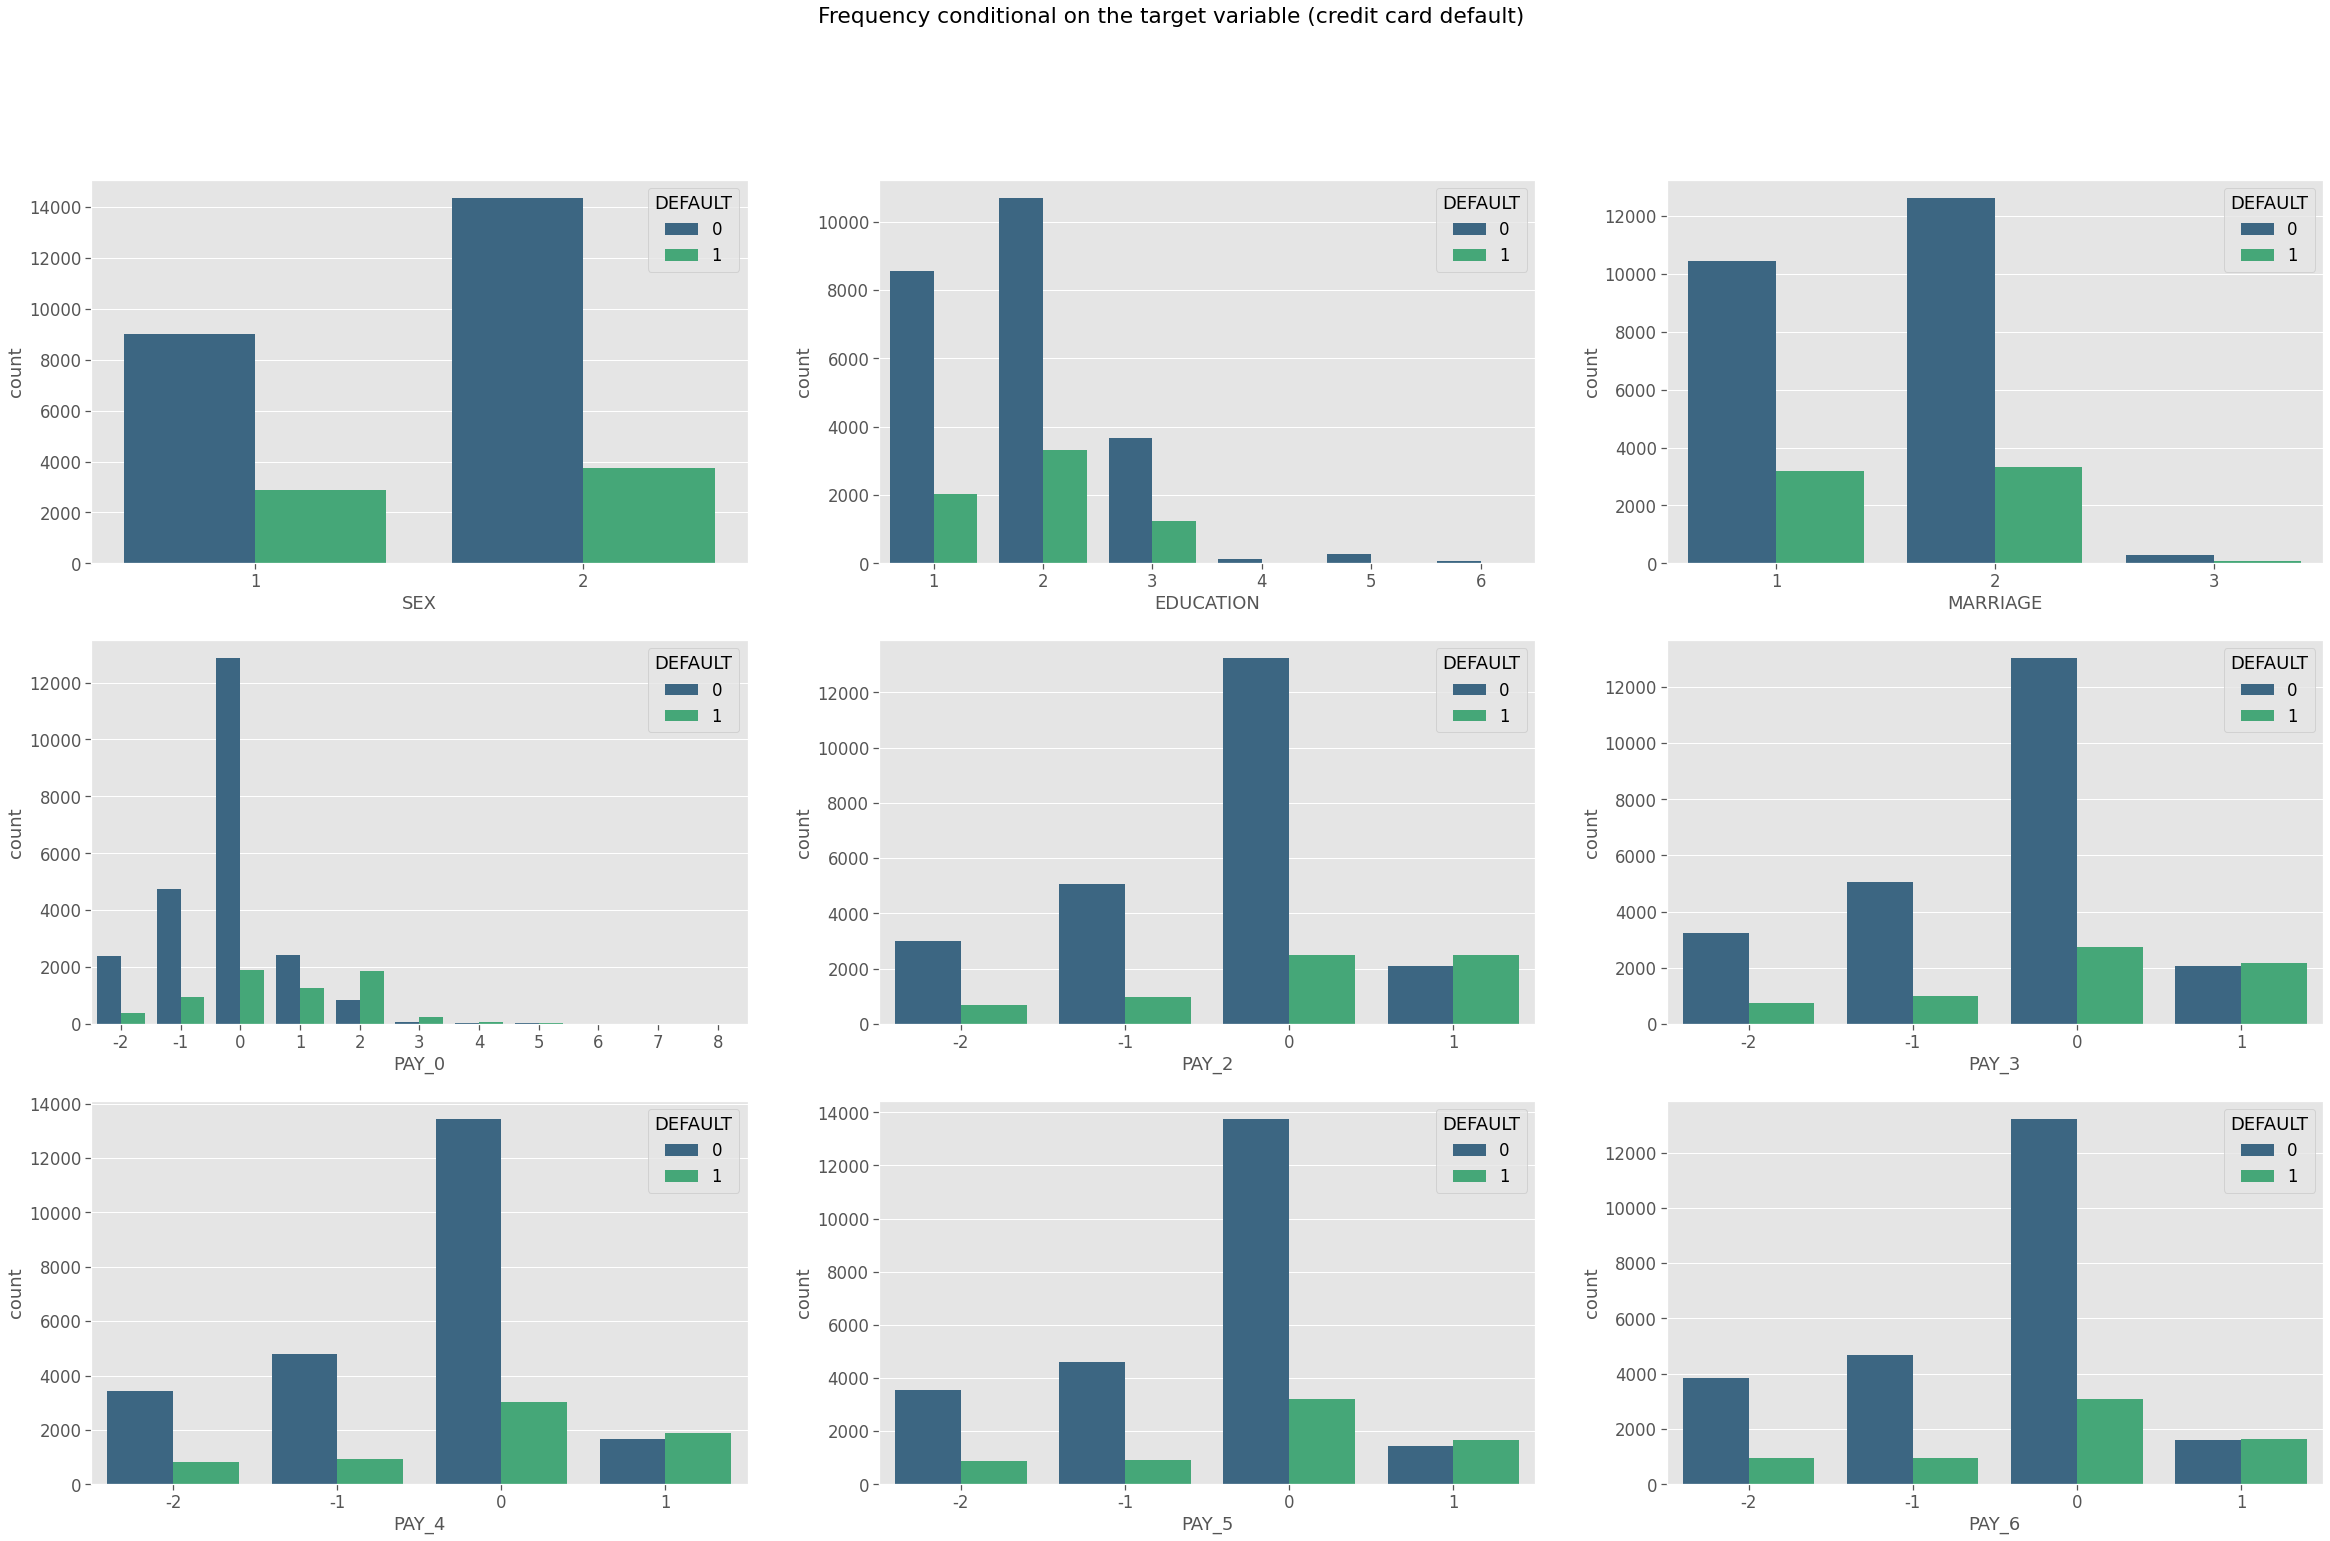

In [ ]:
# EDA: Categorical variables count conditional on the credit card defaults
df_ccd_cat = df_ccd[['SEX', 'EDUCATION', 'MARRIAGE', 
                     'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 
                     'PAY_5', 'PAY_6', 'DEFAULT']]
fig, axes = plt.subplots(3, 3, figsize=(40, 24), facecolor='white')
fig.suptitle('Frequency conditional on the target variable (credit card default)')
ax1 = sns.countplot(x='SEX', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[0,0])
ax2 = sns.countplot(x='EDUCATION', hue='DEFAULT', data=df_ccd_cat, palette='viridis',ax=axes[0,1])
ax3 = sns.countplot(x='MARRIAGE', hue='DEFAULT', data=df_ccd_cat, palette='viridis',ax=axes[0,2])
ax4 = sns.countplot(x='PAY_0', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[1,0])
ax5 = sns.countplot(x='PAY_2', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[1,1])
ax6 = sns.countplot(x='PAY_3', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[1,2])
ax7 = sns.countplot(x='PAY_4', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[2,0])
ax8 = sns.countplot(x='PAY_5', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[2,1])
ax9 = sns.countplot(x='PAY_6', hue='DEFAULT', data=df_ccd_cat, palette='viridis', ax=axes[2,2])
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


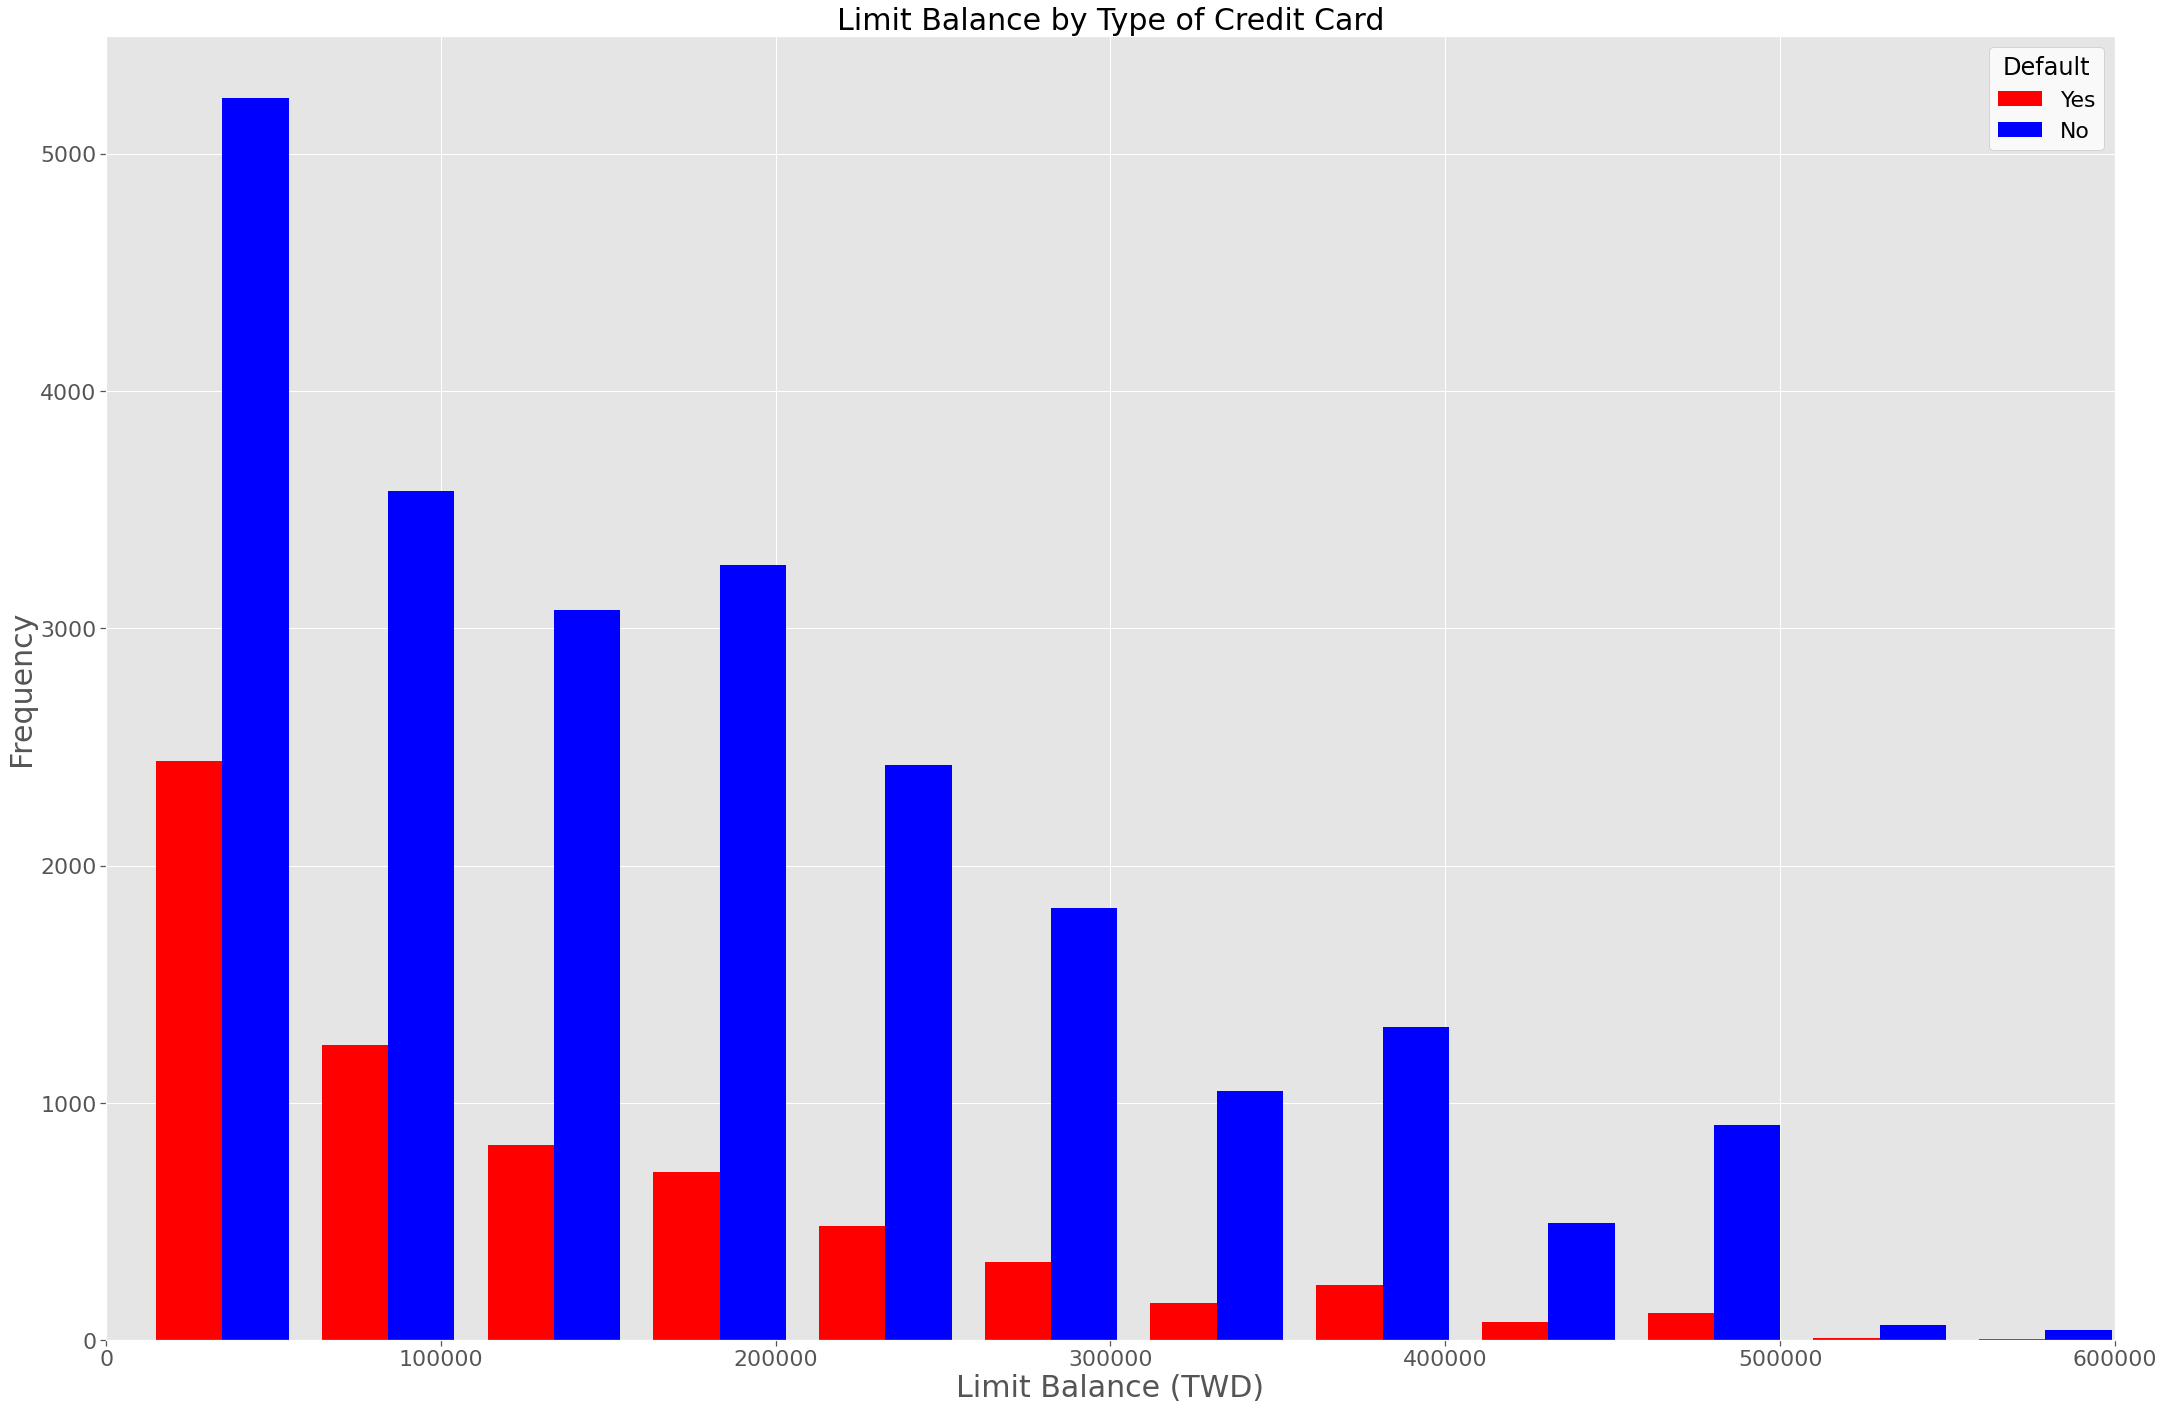

In [ ]:
# EDA: Limit balance distribution conditional on the credit card defaults
x1 = list(df_ccd[df_ccd['DEFAULT'] == 1]['LIMIT_BAL'])
x2 = list(df_ccd[df_ccd['DEFAULT'] == 0]['LIMIT_BAL'])

plt.figure(figsize=(36,24))
sns.set_context('notebook', font_scale=2)
plt.hist([x1, x2], bins = 20, color=['red', 'blue'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (TWD)', size=30)
plt.ylabel('Frequency', size=30)
plt.title('Limit Balance by Type of Credit Card', size=30)
plt.show()

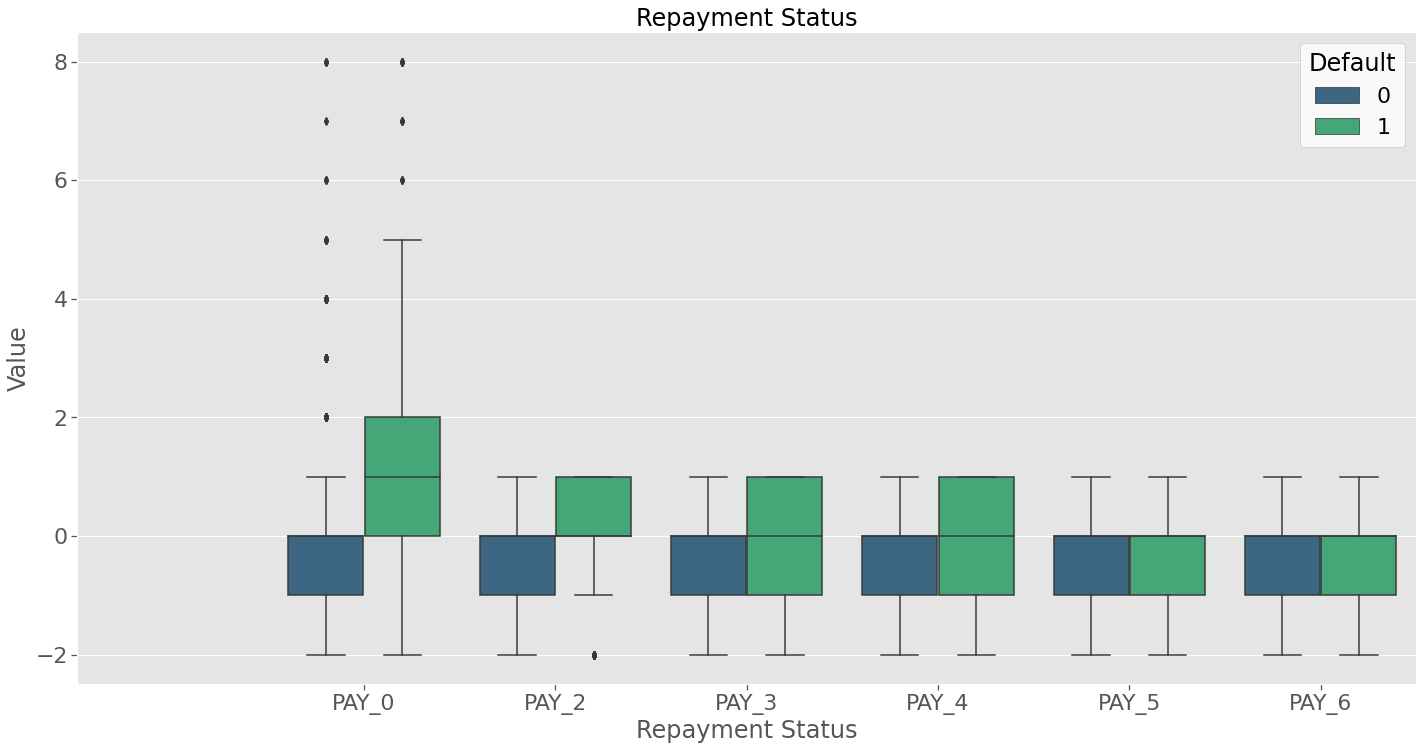

In [ ]:
# EDA: Repayment status conditional on the credit card defaults
df_ccd_repayment = df_ccd[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

df_ccd_repayment = pd.concat([y,df_ccd_repayment],axis=1)
df_ccd_repayment = pd.melt(df_ccd_repayment,id_vars='DEFAULT',
                           var_name='Repayment Status',
                           value_name='Value')

plt.figure(figsize=(24,12))
sns.set_context('notebook', font_scale=2)
sns.boxplot(y='Value', x='Repayment Status', hue='DEFAULT', data=df_ccd_repayment, palette='viridis')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('Repayment Status', size=24)
plt.show()

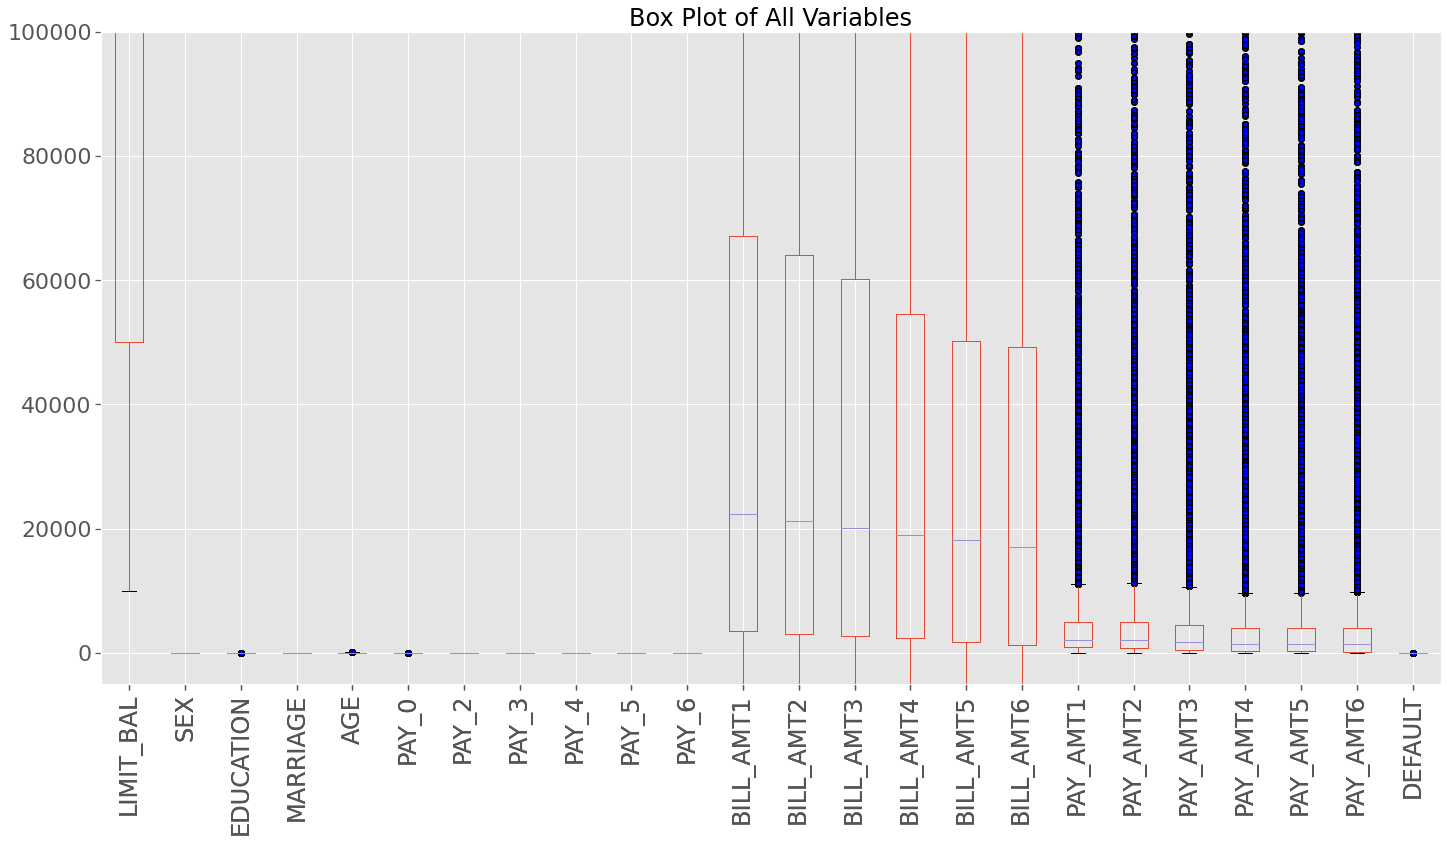

In [ ]:
## EDA: Box plot of all variables
plt.figure(figsize=(24,12))
ax = df_ccd.boxplot(df_ccd.columns.name, rot=90)
outliers = dict(markerfacecolor='b', marker='p')
ax= df_ccd.boxplot(df_ccd.columns.name, rot=90, flierprops=outliers)
plt.xticks(size=24)
plt.title('Box Plot of All Variables', size=24)
ax.set_ylim([-5000,100000])
plt.show()

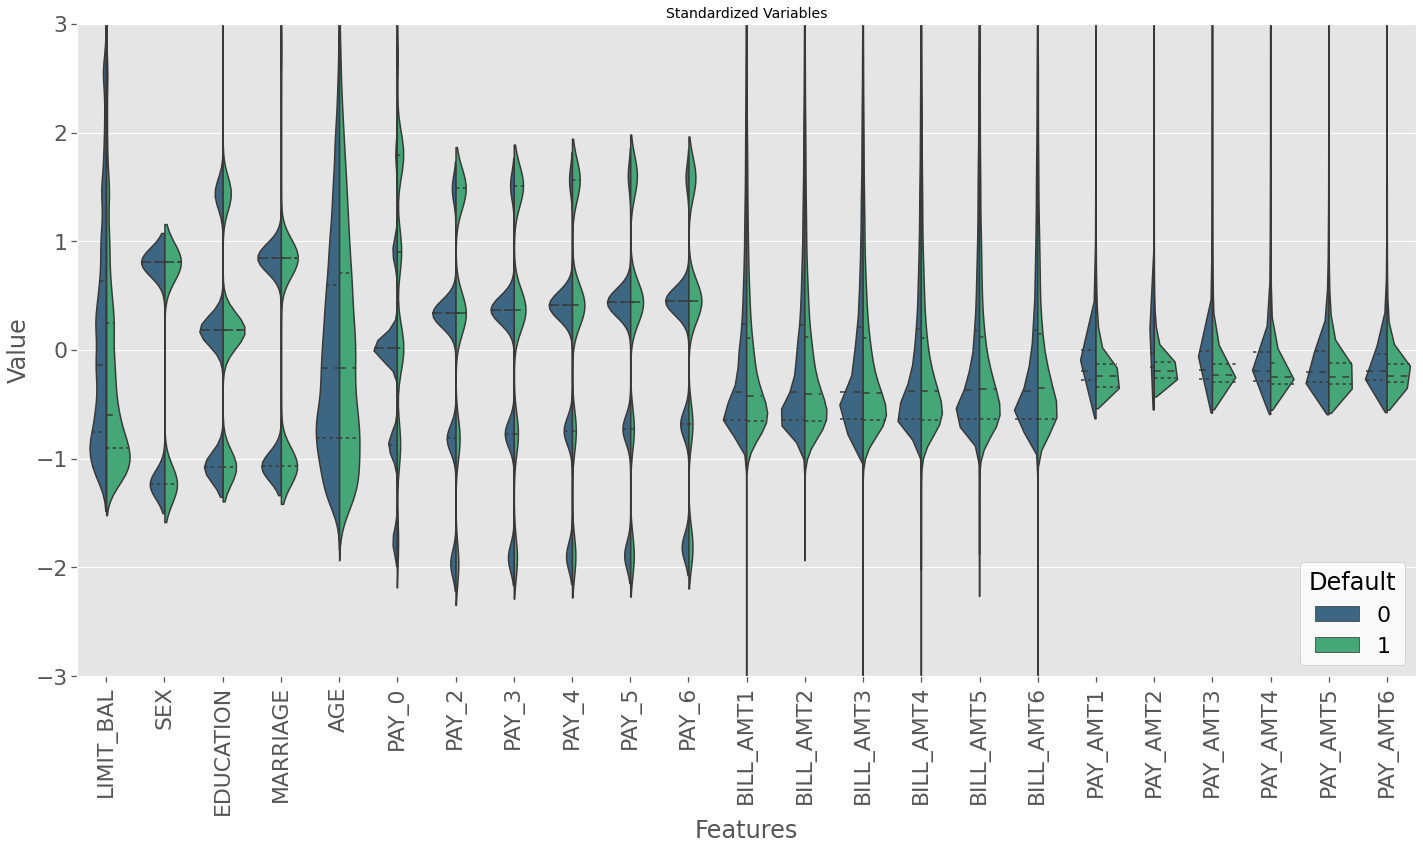

In [ ]:
# EDA: Standardization 
X_scaled = (X - X.mean()) / (X.std())              
df_ccd_scaled = pd.concat([y,X_scaled.iloc[:,:]],axis=1)
df_ccd_scaled = pd.melt(df_ccd_scaled, id_vars='DEFAULT', var_name='Features', value_name='Value')

plt.figure(figsize=(24,12))
sns.set_context('notebook', font_scale=2)
ax = sns.violinplot(y='Value', x='Features', hue='DEFAULT', data=df_ccd_scaled, split=True, 
                    inner='quart', palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.legend(loc=4, title= 'Default', facecolor='white')
plt.ylim([-3,3])
plt.title('Standardized Variables', size=14)
plt.show()

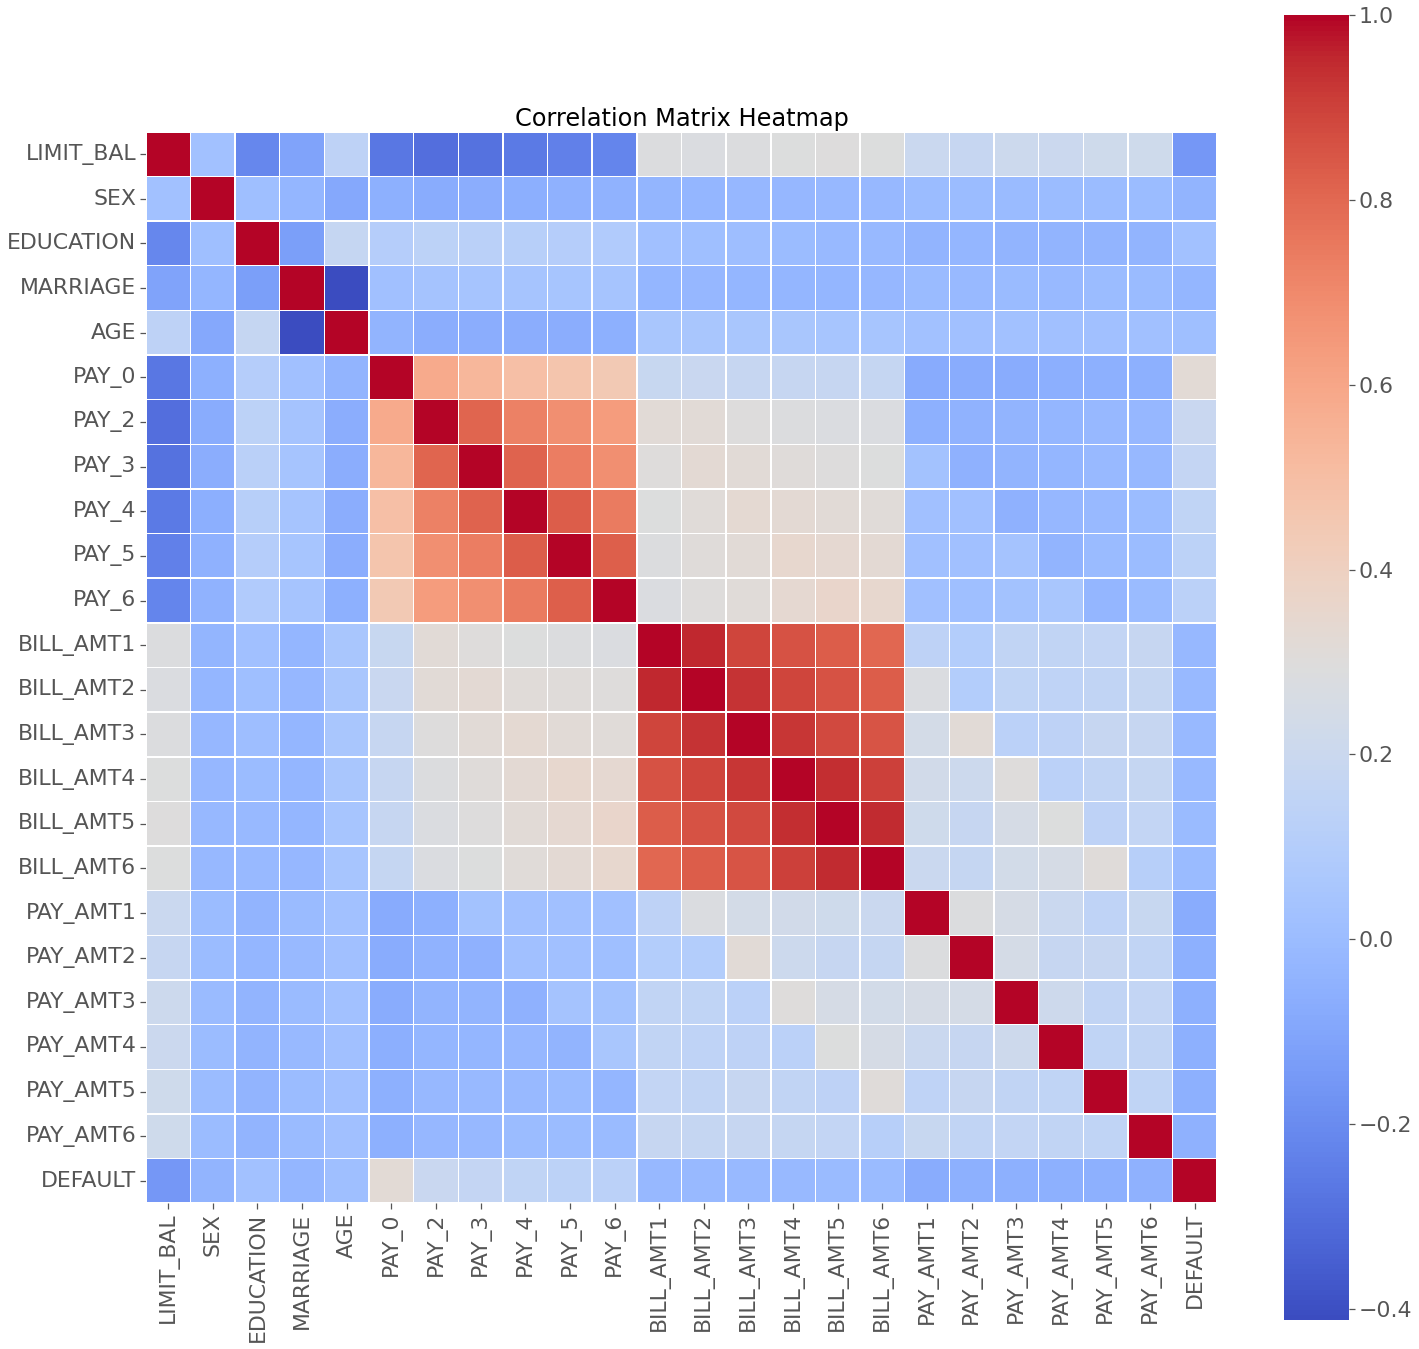

In [ ]:
# EDA: Correlations 
corr = df_ccd.corr() 
fig, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True, cmap='coolwarm', linewidths=.5, ax=ax)
plt.title('Correlation Matrix Heatmap', size=24)
plt.show()

<font color='Green'><left><b>
We first do the train - test split in order not to have data leakage.
</b></left></font>

In [ ]:
# Model: Create train and test datasets (original and standardized features)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

<font color='Green'><left><b>
We are starting preprocessing.
</b></left></font>

<font color='Green'><left><b>
First - original one.
</b></left></font>

In [ ]:
X_train_first = X_train.copy()
X_test_first = X_test.copy()
y_train_first = y_train.copy()
y_test_first = y_test.copy()

<font color='Green'><left><b>
Second - treatment of outliers and feature number reduction using SelectKBest.
</b></left></font>

In [ ]:
X_train_second = X_train.copy()
X_test_second = X_test.copy()
y_train_second = y_train.copy()
y_test_second = y_test.copy()

In [ ]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
#import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#Most important features on purpose set to 23 (Number of variables in X)
test = SelectKBest(k=23)
fit = test.fit(X_train_second, y_train_second)
np.set_printoptions(precision=3)
df=pd.DataFrame(fit.scores_,index=X.columns,columns=['Most Important Features'])

df.sort_values(by='Most Important Features',ascending=False)

,Most Important Features
PAY_0,2886.54469
PAY_2,956.05850
PAY_3,770.87570
LIMIT_BAL,638.56702
PAY_4,625.92911
PAY_5,488.59326
PAY_6,436.09211
PAY_AMT1,130.13708
PAY_AMT2,102.06744
PAY_AMT4,73.64695


In [ ]:
#Selecting 7 most important features
X_train_second_reduced=X_train_second.drop(list(df.sort_values(by='Most Important Features',ascending=False).index[7:]), axis = 1, inplace = False)
X_test_second_reduced=X_test_second.drop(list(df.sort_values(by='Most Important Features',ascending=False).index[7:]), axis = 1, inplace = False)


In [ ]:
#Train-test treatment

#Idea behind it is if we have Normal(0,1) than variables can't take values higher than 4 in abs value


X_scaled_train_second_reduced = (X_train_second_reduced - X_train_second_reduced.mean()) / (X_train_second_reduced.std())         
X_scaled_test_second_reduced = (X_test_second_reduced - X_test_second_reduced.mean()) / (X_test_second_reduced.std())         

X_scaled_train_second_reduced.apply(lambda x:(x>4)|(x<-4)).apply(lambda x: sum(x))

LIMIT_BAL    26
PAY_0        53
PAY_2         0
PAY_3         0
PAY_4         0
PAY_5         0
PAY_6         0
dtype: int64

In [ ]:
#Trimming values greater than 4 for non-defaulters (Because it is okay for high limit balance outlier to default)
pay_0_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_0'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_0'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
pay_2_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_2'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_2'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
pay_3_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_3'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_3'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
pay_4_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_4'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_4'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
pay_5_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_5'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_5'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
pay_6_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_6'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['PAY_6'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)
limit_bal_train_duplicates_index=list(y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['LIMIT_BAL'].apply(lambda x:(x>4)|(x<-4))==True].index][y_train_second[X_scaled_train_second_reduced[X_scaled_train_second_reduced['LIMIT_BAL'].apply(lambda x:(x>4)|(x<-4))==True].index]==0].index)

all_duplicates_index_train=pay_0_train_duplicates_index+pay_2_train_duplicates_index+pay_3_train_duplicates_index+pay_4_train_duplicates_index+pay_5_train_duplicates_index+pay_5_train_duplicates_index+pay_6_train_duplicates_index+limit_bal_train_duplicates_index
#find unique indexes for duplicates
duplicates_unique_train=list(dict.fromkeys(all_duplicates_index_train))

In [ ]:
#Dropping outliers in train
X_scaled_train_second_reduced.drop(index=duplicates_unique_train,inplace=True)
y_train_second.drop(index=duplicates_unique_train,inplace=True)

<font color='Green'><left><b>
We'll check for outliers.
</b></left></font>

In [ ]:
#train
#all these are defaulters
X_scaled_train_second_reduced.apply(lambda x:(x>4)|(x<-4)).apply(lambda x: sum(x))

LIMIT_BAL     3
PAY_0        29
PAY_2         0
PAY_3         0
PAY_4         0
PAY_5         0
PAY_6         0
dtype: int64

<font color='Green'><left><b>
Third - treatment of outliers and nonlinear data transformation.
</b></left></font>

In [ ]:
X_train_third = X_train.copy()
X_test_third = X_test.copy()
y_train_third = y_train.copy()
y_test_third = y_test.copy()

<font color='Green'><left><b>
Clipping the outliers
</b></left></font>

In [ ]:
X_train_third=X_train_third.clip(lower=X_train_third.quantile(0.01), upper=X_train_third.quantile(0.99), axis=1)

<font color='Green'><left><b>
We empiricaly found that best fit gives -   
AGE transform with Box-Cox and  
LIMIT_BAL, PAY_AMTx and BILL_AMTx with Quantile Transformer
</b></left></font>

In [ ]:
#Transformation and standardization
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
power_transformer_bc = PowerTransformer(method='box-cox', standardize=True)
power_transformer_yj = PowerTransformer(method='yeo-johnson', standardize=True)
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=0,)

power_transformer_bc.fit(X_train_third[['AGE']])
X_train_third['AGE']=power_transformer_bc.transform(X_train_third[['AGE']])
X_test_third['AGE']=power_transformer_bc.transform(X_test_third[['AGE']])

quantile_transformer.fit(X_train_third[['LIMIT_BAL']])
X_train_third['LIMIT_BAL']=quantile_transformer.transform(X_train_third[['LIMIT_BAL']])
X_test_third['LIMIT_BAL']=quantile_transformer.transform(X_test_third[['LIMIT_BAL']])

quantile_transformer.fit(X_train_third[['PAY_AMT1']])
X_train_third['PAY_AMT1']=quantile_transformer.transform(X_train_third[['PAY_AMT1']])
X_test_third['PAY_AMT1']=quantile_transformer.transform(X_test_third[['PAY_AMT1']])

quantile_transformer.fit(X_train_third[['PAY_AMT2']])
X_train_third['PAY_AMT2']=quantile_transformer.transform(X_train_third[['PAY_AMT2']])
X_test_third['PAY_AMT2']=quantile_transformer.transform(X_test_third[['PAY_AMT2']])

quantile_transformer.fit(X_train_third[['PAY_AMT3']])
X_train_third['PAY_AMT3']=quantile_transformer.transform(X_train_third[['PAY_AMT3']])
X_test_third['PAY_AMT3']=quantile_transformer.transform(X_test_third[['PAY_AMT3']])

quantile_transformer.fit(X_train_third[['PAY_AMT4']])
X_train_third['PAY_AMT4']=quantile_transformer.transform(X_train_third[['PAY_AMT4']])
X_test_third['PAY_AMT4']=quantile_transformer.transform(X_test_third[['PAY_AMT4']])

quantile_transformer.fit(X_train_third[['PAY_AMT5']])
X_train_third['PAY_AMT5']=quantile_transformer.transform(X_train_third[['PAY_AMT5']])
X_test_third['PAY_AMT5']=quantile_transformer.transform(X_test_third[['PAY_AMT5']])

quantile_transformer.fit(X_train_third[['PAY_AMT6']])
X_train_third['PAY_AMT6']=quantile_transformer.transform(X_train_third[['PAY_AMT6']])
X_test_third['PAY_AMT6']=quantile_transformer.transform(X_test_third[['PAY_AMT6']])

quantile_transformer.fit(X_train_third[['BILL_AMT1']])
X_train_third['BILL_AMT1']=quantile_transformer.transform(X_train_third[['BILL_AMT1']])
X_test_third['BILL_AMT1']=quantile_transformer.transform(X_test_third[['BILL_AMT1']])

quantile_transformer.fit(X_train_third[['BILL_AMT2']])
X_train_third['BILL_AMT2']=quantile_transformer.transform(X_train_third[['BILL_AMT2']])
X_test_third['BILL_AMT2']=quantile_transformer.transform(X_test_third[['BILL_AMT2']])

quantile_transformer.fit(X_train_third[['BILL_AMT3']])
X_train_third['BILL_AMT3']=quantile_transformer.transform(X_train_third[['BILL_AMT3']])
X_test_third['BILL_AMT3']=quantile_transformer.transform(X_test_third[['BILL_AMT3']])

quantile_transformer.fit(X_train_third[['BILL_AMT4']])
X_train_third['BILL_AMT4']=quantile_transformer.transform(X_train_third[['BILL_AMT4']])
X_test_third['BILL_AMT4']=quantile_transformer.transform(X_test_third[['BILL_AMT4']])

quantile_transformer.fit(X_train_third[['BILL_AMT5']])
X_train_third['BILL_AMT5']=quantile_transformer.transform(X_train_third[['BILL_AMT5']])
X_test_third['BILL_AMT5']=quantile_transformer.transform(X_test_third[['BILL_AMT5']])

quantile_transformer.fit(X_train_third[['BILL_AMT6']])
X_train_third['BILL_AMT6']=quantile_transformer.transform(X_train_third[['BILL_AMT6']])
X_test_third['BILL_AMT6']=quantile_transformer.transform(X_test_third[['BILL_AMT6']])


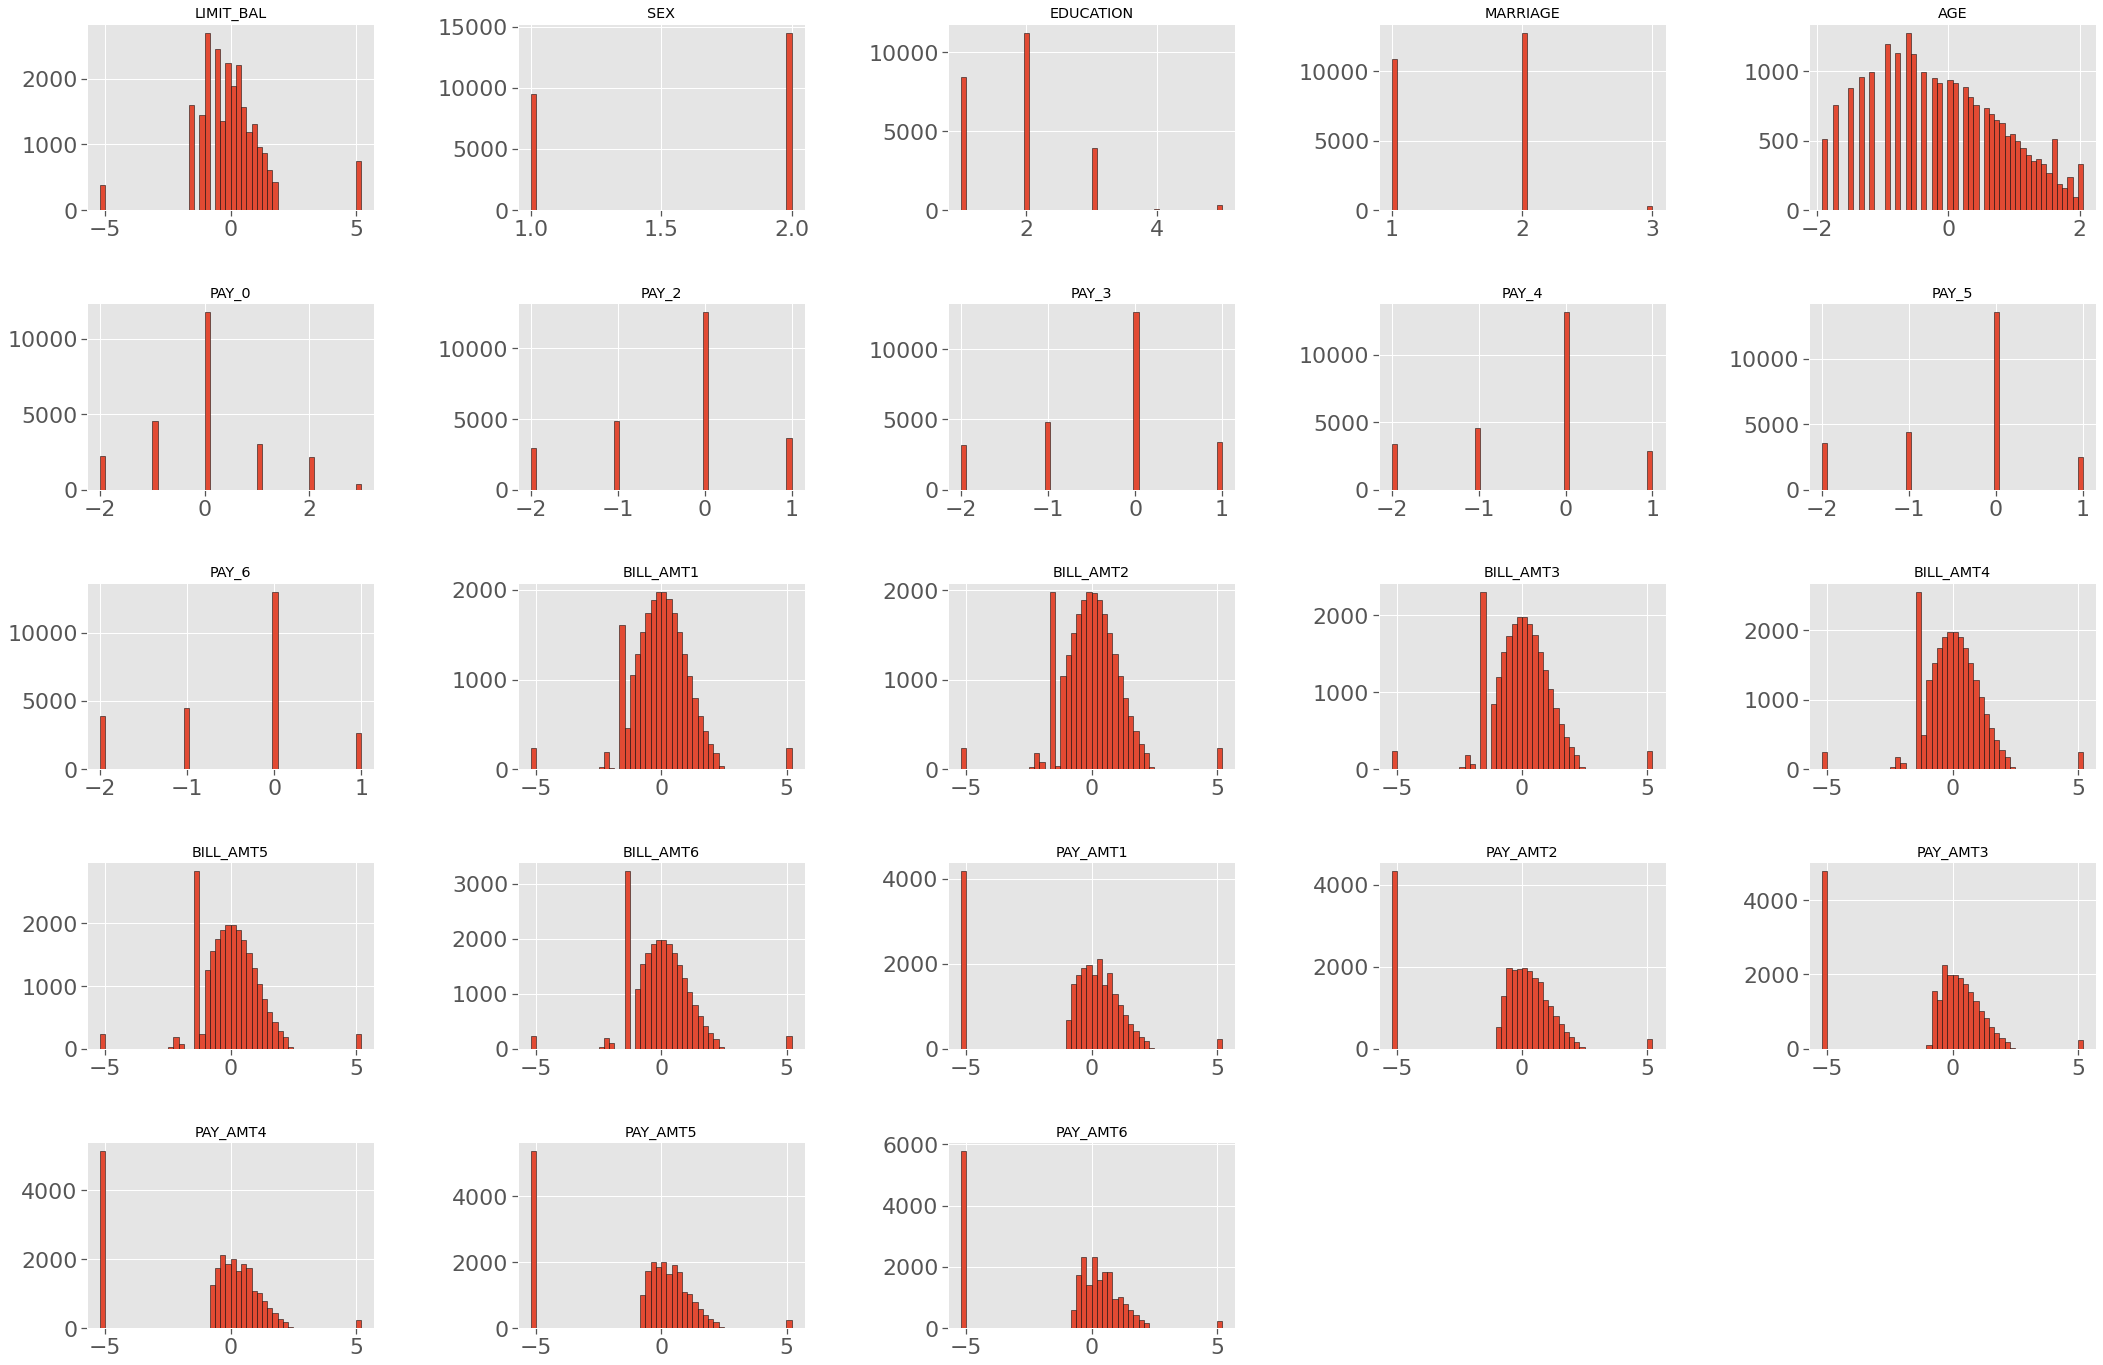

In [ ]:
# EDA: Plot histograms for all variables (features + target)
X_train_third.hist(figsize=(36, 24), bins=50, edgecolor='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

<font color='Green'><left><b>
Fourth - Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT followed by standard scaling.
</b></left></font>

In [ ]:
X_train_forth = X_train.copy()
X_test_forth = X_test.copy()
y_train_forth = y_train.copy()
y_test_forth = y_test.copy()
X_train_forth.reset_index(inplace=True)
X_test_forth.reset_index(inplace=True)

In [ ]:
from sklearn.decomposition import PCA
#2 We define PCA components for all
pca = PCA(n_components=2)

In [ ]:
#PCA components for PAY
X_train_PCA_PAY = pca.fit_transform(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('PAY_[0-9]')]])
X_test_PCA_PAY = pca.transform(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('PAY_[0-9]')]])

X_train_PCA_PAY_DF = pd.DataFrame(data = X_train_PCA_PAY
             , columns = ['PCA_PAY1', 'PCA_PAY2'])
X_test_PCA_PAY_DF = pd.DataFrame(data = X_test_PCA_PAY
             , columns = ['PCA_PAY1', 'PCA_PAY2'])


X_train_forth = pd.concat([X_train_forth, X_train_PCA_PAY_DF], axis = 1)
X_test_forth = pd.concat([X_test_forth, X_test_PCA_PAY_DF], axis = 1)

X_train_forth=X_train_forth.drop(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('PAY_[0-9]')]],axis=1)
X_test_forth=X_test_forth.drop(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('PAY_[0-9]')]],axis=1)


In [ ]:
#PCA components for PAY_AMT
X_train_PCA_PAY_AMT = pca.fit_transform(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('PAY_AMT')]])
X_test_PCA_PAY_AMT = pca.transform(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('PAY_AMT')]])

X_train_PCA_PAY_AMT_DF = pd.DataFrame(data = X_train_PCA_PAY_AMT
             , columns = ['PCA_PAY_AMT_1', 'PCA_PAY_AMT_2'])
X_test_PCA_PAY_AMT_DF = pd.DataFrame(data = X_test_PCA_PAY_AMT
             , columns = ['PCA_PAY_AMT_1', 'PCA_PAY_AMT_2'])


X_train_forth = pd.concat([X_train_forth, X_train_PCA_PAY_AMT_DF], axis = 1)
X_test_forth = pd.concat([X_test_forth, X_test_PCA_PAY_AMT_DF], axis = 1)

X_train_forth=X_train_forth.drop(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('PAY_AMT[0-9]')]],axis=1)
X_test_forth=X_test_forth.drop(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('PAY_AMT[0-9]')]],axis=1)


In [ ]:
#PCA components for BILL_AMT
X_train_PCA_BILL_AMT = pca.fit_transform(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('BILL_AMT')]])
X_test_PCA_BILL_AMT = pca.transform(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('BILL_AMT')]])

X_train_PCA_BILL_AMT_DF = pd.DataFrame(data = X_train_PCA_BILL_AMT
             , columns = ['PCA_BILL_AMT_1', 'PCA_BILL_AMT_2'])
X_test_PCA_BILL_AMT_DF = pd.DataFrame(data = X_test_PCA_BILL_AMT
             , columns = ['PCA_BILL_AMT_1', 'PCA_BILL_AMT_2'])


X_train_forth = pd.concat([X_train_forth, X_train_PCA_BILL_AMT_DF], axis = 1)
X_test_forth = pd.concat([X_test_forth, X_test_PCA_BILL_AMT_DF], axis = 1)

X_train_forth=X_train_forth.drop(X_train_forth[X_train_forth.columns[X_train_forth.columns.str.contains('BILL_AMT[0-9]')]],axis=1)
X_test_forth=X_test_forth.drop(X_test_forth[X_test_forth.columns[X_test_forth.columns.str.contains('BILL_AMT[0-9]')]],axis=1)



In [ ]:
X_train_forth=X_train_forth.drop('index',axis=1)
X_test_forth=X_test_forth.drop('index',axis=1)

In [ ]:
#standard scaling
X_train_forth = (X_train_forth - X_train_forth.mean()) / (X_train_forth.std())
X_test_forth = (X_test_forth - X_test_forth.mean()) / (X_test_forth.std())         


<font color='Green'><left><b>
Evaluation of impact of the proposed data treatments.






</b></left></font>

<font color='Green'><left><b>
GridSearch definition with recall scoring  
We would like to minimize False Negatives as much as posible, since loss of non detected default is greater than the oportunity loss of false detected default.
</b></left></font>

In [ ]:
# Define the cross-validation approach
n_cv_logit = 5

# Define the maximum number of iterations
n_max_iter = 500

# Create an instance of the class LogisticRegression
logit_model = LogisticRegression(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_space['solver']  = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
search_space['C']       = [1e-2, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
logit_grid_search_cv = GridSearchCV(estimator=logit_model, 
                                             param_grid=search_space, 
                                             scoring='recall', 
                                             cv=n_cv_logit, 
                                             n_jobs=-1)

<font color='Green'><left><b>
1) All features without any treatmant - Original features
</b></left></font>

In [ ]:
# Run the search algorithm and summarize resuts 
logit_grid_search_cv.fit(X_train_first, y_train_first)

# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_ccd_first = LogisticRegression(penalty=logit_grid_search_cv.best_params_['penalty'], 
                                        solver=logit_grid_search_cv.best_params_['solver'], 
                                        C=logit_grid_search_cv.best_params_['C'])


# Fit the model
logit_ccd_first.fit(X_train_first, y_train_first)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train_first = logit_ccd_first.predict(X_train_first)

y_pred_test_first  = logit_ccd_first.predict(X_test_first)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is 

<font color='Green'><left><b>
2) Scaling, Feature reduction with SelectKBest, and 4sigma outlier trimming
</b></left></font>

In [ ]:
# Run the search algorithm and summarize resuts

logit_grid_search_cv.fit(X_scaled_train_second_reduced, y_train_second)

# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_ccd_scaled = LogisticRegression(penalty=logit_grid_search_cv.best_params_['penalty'], 
                                        solver=logit_grid_search_cv.best_params_['solver'], 
                                        C=logit_grid_search_cv.best_params_['C'])

# Fit the model
logit_ccd_scaled.fit(X_scaled_train_second_reduced, y_train_second)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train_second = logit_ccd_scaled.predict(X_scaled_train_second_reduced)

y_pred_test_second = logit_ccd_scaled.predict(X_scaled_test_second_reduced)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is 

<font color='Green'><left><b>
3) Data clipped and AGE, LIMIT_BAL, PAY_AMT, BILL_AMT variables scaled and nonlineary transformed
</b></left>

In [ ]:
# Run the search algorithm and summarize resuts

logit_grid_search_cv.fit(X_train_third, y_train_third)

# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_ccd_third = LogisticRegression(penalty=logit_grid_search_cv.best_params_['penalty'], 
                                        solver=logit_grid_search_cv.best_params_['solver'], 
                                        C=logit_grid_search_cv.best_params_['C'])

# Fit the model
logit_ccd_third.fit(X_train_third, y_train_third)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train_third = logit_ccd_third.predict(X_train_third)

y_pred_test_third = logit_ccd_third.predict(X_test_third)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is 

<font color='Green'><left><b>
4) Using PCA for feature reduction for PAY, PAY_AMT, BILL_AMT followed by standard scaling.
</b></left>

In [ ]:
# Run the search algorithm and summarize resuts

logit_grid_search_cv.fit(X_train_forth, y_train_forth)

# Create an instance of the class LogisticRegression with specific selection of hyperparameters
logit_ccd_forth = LogisticRegression(penalty=logit_grid_search_cv.best_params_['penalty'], 
                                        solver=logit_grid_search_cv.best_params_['solver'], 
                                        C=logit_grid_search_cv.best_params_['C'])

# Fit the model
logit_ccd_forth.fit(X_train_forth, y_train_forth)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_pred_train_forth = logit_ccd_forth.predict(X_train_forth)

y_pred_test_forth  = logit_ccd_forth.predict(X_test_forth)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is 

<font color='Green'><left><b>
Comparing Recall scores
</b></left>

<font color='Red'><left><b>
There is an error in lecture notes. It is necessary to change the order of predict and true value:

metrics.accuracy_score(y_scaled_pred_train,y_scaled_train)
</b></left>

In [ ]:
print('All features without any treatmant')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_first,y_pred_train_first):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_first,y_pred_test_first):.4f}')
print(100*'-')
print('Feture reduction with SelectKBest and 4sigma outlier triming')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_pred_train_second):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_pred_test_second):.4f}')
print(100*'-')
print('Data cliped and AGE, LIMIT_BAL, PAY_AMT, BILL_AMT nonlineary transformed')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_third,y_pred_train_third):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_third,y_pred_test_third):.4f}')
print(100*'-')
print('Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_forth,y_pred_train_forth):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_forth,y_pred_test_forth):.4f}')
print(100*'-')


All features without any treatmant
----------------------------------------------------------------------------------------------------
Recall score (train): 0.2488
----------------------------------------------------------------------------------------------------
Recall score (test): 0.2442
----------------------------------------------------------------------------------------------------
Feture reduction with SelectKBest and 4sigma outlier triming
----------------------------------------------------------------------------------------------------
Recall score (train): 0.2814
----------------------------------------------------------------------------------------------------
Recall score (test): 0.2788
----------------------------------------------------------------------------------------------------
Data cliped and AGE, LIMIT_BAL, PAY_AMT, BILL_AMT nonlineary transformed
----------------------------------------------------------------------------------------------------
Recall sco

<font color='Green'><left><b>
Naturally, all data treatmants could be combined.
</b></left>

(b) <b>Optimal Probability Threshold:</b>
- Based on our in-class discussion of the optimal probability threshold, re-run the
classification for logistic regression using a couple of candidate threshold values
that were indicated by the ROC and PR curves (see the lecture notebook).
Hint: You can use the method predict proba instead of the method predict in
LogisticRegression and add one line of code that generates class predictions
based on your selected threshold.

- Compare the models generated using different probability thresholds using the
same key performance evaluation metrics you have applied in the section (a).
Please make sure that the benchmark model (i.e., the model that was studied in
the lecture, and which has the default probability threshold of 0.5) is included.
Discuss your findings.


In [ ]:
#1
# Estimate probabilities, and calculate relevant ROC/AUC scores for the training and testing subsamples 
y_pred_proba_train      = logit_ccd_first.predict_proba(X_train_first)[::,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_first, y_pred_proba_train)
auc_train               = metrics.roc_auc_score(y_train_first, y_pred_proba_train)

y_pred_proba_test      = logit_ccd_first.predict_proba(X_test_first)[::,1]
fpr_test, tpr_test, threshold_test  = metrics.roc_curve(y_test_first, y_pred_proba_test)
auc_test               = metrics.roc_auc_score(y_test_first, y_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_train = np.sqrt(tpr_train * (1-fpr_train))
vec_gmeans_test  = np.sqrt(tpr_test * (1-fpr_test))

# locate the index of the largest g-mean
ix_train = np.argmax(vec_gmeans_train)
ix_test  = np.argmax(vec_gmeans_test)

roc_best_threshold_first = threshold_train[ix_train]

# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_first, y_pred_proba_train)
#average_precision_train                        = metrics.average_precision_score(y_train, y_pred_train)

precision_test, recall_test, threshold_test    = metrics.precision_recall_curve(y_test_first, y_pred_proba_test)
#average_precision_test                         = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
vec_f1_test  = 2 * precision_test * recall_test / (precision_test + recall_test)

# locate the index of the largest F1 score
ix_f1_train = np.argmax(vec_f1_train)
ix_f1_test  = np.argmax(vec_f1_test)

pr_best_threshold_first = threshold_train[ix_f1_train]

In [ ]:
#2
# Estimate probabilities, and calcualate relevant ROC/AUC scores for the training and testing subsamples 
y_pred_proba_train      = logit_ccd_scaled.predict_proba(X_scaled_train_second_reduced)[::,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_second, y_pred_proba_train)
auc_train               = metrics.roc_auc_score(y_train_second, y_pred_proba_train)

y_pred_proba_test      = logit_ccd_scaled.predict_proba(X_scaled_test_second_reduced)[::,1]
fpr_test, tpr_test, threshold_test  = metrics.roc_curve(y_test_second, y_pred_proba_test)
auc_test               = metrics.roc_auc_score(y_test_second, y_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_train = np.sqrt(tpr_train * (1-fpr_train))
vec_gmeans_test  = np.sqrt(tpr_test * (1-fpr_test))

# locate the index of the largest g-mean
ix_train = np.argmax(vec_gmeans_train)
ix_test  = np.argmax(vec_gmeans_test)

roc_best_threshold_second = threshold_train[ix_train]

# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_second, y_pred_proba_train)
#average_precision_train                        = metrics.average_precision_score(y_train, y_pred_train)

precision_test, recall_test, threshold_test    = metrics.precision_recall_curve(y_test_second, y_pred_proba_test)
#average_precision_test                         = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
vec_f1_test  = 2 * precision_test * recall_test / (precision_test + recall_test)

# locate the index of the largest F1 score
ix_f1_train = np.argmax(vec_f1_train)
ix_f1_test  = np.argmax(vec_f1_test)

pr_best_threshold_second = threshold_train[ix_f1_train]

In [ ]:
#3
# Estimate probabilities, and calcualate relevant ROC/AUC scores for the training and testing subsamples 
y_pred_proba_train      = logit_ccd_third.predict_proba(X_train_third)[::,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_third, y_pred_proba_train)
auc_train               = metrics.roc_auc_score(y_train_third, y_pred_proba_train)

y_pred_proba_test      = logit_ccd_third.predict_proba(X_test_third)[::,1]
fpr_test, tpr_test, threshold_test  = metrics.roc_curve(y_test_third, y_pred_proba_test)
auc_test               = metrics.roc_auc_score(y_test_third, y_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_train = np.sqrt(tpr_train * (1-fpr_train))
vec_gmeans_test  = np.sqrt(tpr_test * (1-fpr_test))

# locate the index of the largest g-mean
ix_train = np.argmax(vec_gmeans_train)
ix_test  = np.argmax(vec_gmeans_test)

roc_best_threshold_third = threshold_train[ix_train]

# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_third, y_pred_proba_train)
#average_precision_train                        = metrics.average_precision_score(y_train, y_pred_train)

precision_test, recall_test, threshold_test    = metrics.precision_recall_curve(y_test_third, y_pred_proba_test)
#average_precision_test                         = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
vec_f1_test  = 2 * precision_test * recall_test / (precision_test + recall_test)

# locate the index of the largest F1 score
ix_f1_train = np.argmax(vec_f1_train)
ix_f1_test  = np.argmax(vec_f1_test)

pr_best_threshold_third = threshold_train[ix_f1_train]

In [ ]:
#4
# Estimate probabilities, and calcualate relevant ROC/AUC scores for the training and testing subsamples 
y_pred_proba_train      = logit_ccd_forth.predict_proba(X_train_forth)[::,1]
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_forth, y_pred_proba_train)
auc_train               = metrics.roc_auc_score(y_train_forth, y_pred_proba_train)

y_pred_proba_test      = logit_ccd_forth.predict_proba(X_test_forth)[::,1]
fpr_test, tpr_test, threshold_test  = metrics.roc_curve(y_test_forth, y_pred_proba_test)
auc_test               = metrics.roc_auc_score(y_test_forth, y_pred_proba_test)

# Calculate the geometric mean for each threshold for the training and testing subsamples
vec_gmeans_train = np.sqrt(tpr_train * (1-fpr_train))
vec_gmeans_test  = np.sqrt(tpr_test * (1-fpr_test))

# locate the index of the largest g-mean
ix_train = np.argmax(vec_gmeans_train)
ix_test  = np.argmax(vec_gmeans_test)

roc_best_threshold_forth = threshold_train[ix_train]

# Calculate the precision and recall for different values of threshold in the training and testing subsamples
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_forth, y_pred_proba_train)
#average_precision_train                        = metrics.average_precision_score(y_train, y_pred_train)

precision_test, recall_test, threshold_test    = metrics.precision_recall_curve(y_test_forth, y_pred_proba_test)
#average_precision_test                         = metrics.average_precision_score(y_test, y_pred_test)

# Calculate the F1 score
vec_f1_train = 2 * precision_train * recall_train / (precision_train + recall_train)
vec_f1_test  = 2 * precision_test * recall_test / (precision_test + recall_test)

# locate the index of the largest F1 score
ix_f1_train = np.argmax(vec_f1_train)
ix_f1_test  = np.argmax(vec_f1_test)

pr_best_threshold_forth = threshold_train[ix_f1_train]

In [ ]:
print(100*'-')
print('1. Original case   -   Threshold = 0.5')
print(100*'-')
print('2. Best threshold ROC = %.3f, PR = %.3f' % (roc_best_threshold_second, pr_best_threshold_second))
print(100*'-')
print('3. Best threshold ROC = %.3f, PR = %.3f' % (roc_best_threshold_third, pr_best_threshold_third))
print(100*'-')
print('4. Best threshold ROC = %.3f, PR = %.3f' % (roc_best_threshold_forth, pr_best_threshold_forth))
print(100*'-')

----------------------------------------------------------------------------------------------------
1. Original case   -   Threshold = 0.5
----------------------------------------------------------------------------------------------------
2. Best threshold ROC = 0.230, PR = 0.253
----------------------------------------------------------------------------------------------------
3. Best threshold ROC = 0.234, PR = 0.306
----------------------------------------------------------------------------------------------------
4. Best threshold ROC = 0.239, PR = 0.283
----------------------------------------------------------------------------------------------------


In [ ]:

# To be used when one wants to change the threshold

y_pred_train_proba_second_rc = (logit_ccd_scaled.predict_proba(X_scaled_train_second_reduced)[:,1]>=roc_best_threshold_second).astype(int)
y_pred_train_proba_second_pr = (logit_ccd_scaled.predict_proba(X_scaled_train_second_reduced)[:,1]>=pr_best_threshold_second).astype(int)

y_pred_test_proba_second_rc = (logit_ccd_scaled.predict_proba(X_scaled_test_second_reduced)[:,1]>=roc_best_threshold_second).astype(int)
y_pred_test_proba_second_pr = (logit_ccd_scaled.predict_proba(X_scaled_test_second_reduced)[:,1]>=pr_best_threshold_second).astype(int)

y_pred_train_proba_third_rc = (logit_ccd_third.predict_proba(X_train_third)[:,1]>=roc_best_threshold_third).astype(int)
y_pred_train_proba_third_pr = (logit_ccd_third.predict_proba(X_train_third)[:,1]>=pr_best_threshold_third).astype(int)

y_pred_test_proba_third_rc = (logit_ccd_third.predict_proba(X_test_third)[:,1]>=roc_best_threshold_third).astype(int)
y_pred_test_proba_third_pr = (logit_ccd_third.predict_proba(X_test_third)[:,1]>=pr_best_threshold_third).astype(int)

y_pred_train_proba_forth_rc = (logit_ccd_forth.predict_proba(X_train_forth)[:,1]>=roc_best_threshold_forth).astype(int)
y_pred_train_proba_forth_pr = (logit_ccd_forth.predict_proba(X_train_forth)[:,1]>=pr_best_threshold_forth).astype(int)

y_pred_test_proba_forth_rc = (logit_ccd_forth.predict_proba(X_test_forth)[:,1]>=roc_best_threshold_forth).astype(int)
y_pred_test_proba_forth_pr = (logit_ccd_forth.predict_proba(X_test_forth)[:,1]>=pr_best_threshold_forth).astype(int)

In [ ]:
print('1. All features without any treatmant')
print(100*'-')
print('Thresholds - 0.5          : %.3f'% 0.5)
print(100*'-')
print(f'Recall score (train)      : {metrics.recall_score(y_train_first,y_pred_train_first):.3f}')
print(100*'-')
print(f'Recall score (test)       : {metrics.recall_score(y_test_first,y_pred_test_first):.3f}')
print(100*'-')
print('2. Feture reduction with SelectKBest and 4sigma outlier triming')
print(100*'-')
print('Thresholds - 0.5, ROC, PR : %.3f, %.3f, %.3f' % (0.5,roc_best_threshold_second, pr_best_threshold_second))
print(100*'-')
print(f'Recall score (train)      : {metrics.recall_score(y_train_second,y_pred_train_second):.3f}, {metrics.recall_score(y_train_second,y_pred_train_proba_second_rc):.3f}, {metrics.recall_score(y_train_second,y_pred_train_proba_second_pr):.3f}')
print(100*'-')
print(f'Recall score (test)       : {metrics.recall_score(y_test_second,y_pred_test_second):.3f}, {metrics.recall_score(y_test_second,y_pred_test_proba_second_rc):.3f}, {metrics.recall_score(y_test_second,y_pred_test_proba_second_pr):.3f}')
print(100*'-')
print('3. Data cliped and AGE, LIMIT_BAL, PAY_AMT, BILL_AMT nonlineary transformed')
print(100*'-')
print('Thresholds - 0.5, ROC, PR : %.3f, %.3f, %.3f' % (0.5,roc_best_threshold_third, pr_best_threshold_third))
print(100*'-')
print(f'Recall score (train)      : {metrics.recall_score(y_train_third,y_pred_train_third):.3f}, {metrics.recall_score(y_train_third,y_pred_train_proba_third_rc):.3f}, {metrics.recall_score(y_train_third,y_pred_train_proba_third_pr):.3f}')
print(100*'-')
print(f'Recall score (test)       : {metrics.recall_score(y_test_third,y_pred_test_third):.3f}, {metrics.recall_score(y_test_third,y_pred_test_proba_third_rc):.3f}, {metrics.recall_score(y_test_third,y_pred_test_proba_third_pr):.3f}')
print(100*'-')
print('4. Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after')
print(100*'-')
print('Thresholds - 0.5, ROC, PR : %.3f, %.3f, %.3f' % (0.5,roc_best_threshold_forth, pr_best_threshold_forth))
print(100*'-')
print(f'Recall score (train)      : {metrics.recall_score(y_train_forth,y_pred_train_forth):.3f}, {metrics.recall_score(y_train_forth,y_pred_train_proba_forth_rc):.3f}, {metrics.recall_score(y_train_forth,y_pred_train_proba_forth_pr):.3f}')
print(100*'-')
print(f'Recall score (test)       : {metrics.recall_score(y_test_forth,y_pred_test_forth):.3f}, {metrics.recall_score(y_test_forth,y_pred_test_proba_forth_rc):.3f}, {metrics.recall_score(y_test_forth,y_pred_test_proba_forth_pr):.3f}')
print(100*'-')

1. All features without any treatmant
----------------------------------------------------------------------------------------------------
Thresholds - 0.5          : 0.500
----------------------------------------------------------------------------------------------------
Recall score (train)      : 0.249
----------------------------------------------------------------------------------------------------
Recall score (test)       : 0.244
----------------------------------------------------------------------------------------------------
2. Feture reduction with SelectKBest and 4sigma outlier triming
----------------------------------------------------------------------------------------------------
Thresholds - 0.5, ROC, PR : 0.500, 0.230, 0.253
----------------------------------------------------------------------------------------------------
Recall score (train)      : 0.281, 0.601, 0.519
----------------------------------------------------------------------------------------------

# 2   Horse Races of Classification Methods

Based on your results and conclusions drawn from the logistic regression analysis, generate the key performance evaluation metrics of your choice for logistic regression, linear SVC, KNN, decision tree, and random forest algorithms. Report the results in a tabular format. Use the transformed features to run the analysis for all the models. For the optimal
probability threshold, select the value that resulted in best performance of the logisticregression-based classification in the section (b) of the first problem.
Remark: You can consider either the scaled features with or without additional data preprocessing, depending on the conclusions drawn in the part (a) of the first problem.


<font color='Green'><left><b>
Since best test recall score was in second aporoach with ROC treshold 0.230, we will continue using this data set.
</b></left>

<font color='Green'><left><b>
Linear SVC
</b></left>

In [ ]:
# Define the cross-validation approach
n_cv_lsvc = 5

# Define the maximum number of iterations
n_max_iter = 2000

# Create an instance of the class LinearSVC
lsvc_model = LinearSVC(max_iter=n_max_iter)

# Define the search space for the hyperparameters
search_space = dict()
search_space['penalty'] = ['l1', 'l2']
search_space['loss']    = ['hinge', 'squared_hinge']
search_space['C']       = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Create an instance of the class GridSearchCV with desired characteristics
lsvc_grid_search_cv_scaled = GridSearchCV(estimator=lsvc_model, 
                                          param_grid=search_space, 
                                          scoring='recall', 
                                          cv=n_cv_lsvc, 
                                          n_jobs=-1)

# Run the search algorithm and summarize resuts 
lsvc_grid_search_cv_scaled.fit(X_scaled_train_second_reduced, y_train_second)

print(f'Best score: {lsvc_grid_search_cv_scaled.best_score_:.4f}')
print('Best hyperparameters: %s' % lsvc_grid_search_cv_scaled.best_params_)

Best score: 0.4683
Best hyperparameters: {'C': 1e-05, 'loss': 'hinge', 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/usr/loc

In [ ]:
# Create an instance of the class LinearSVC with specific selection of hyperparameters
lsvc_ccd_scaled = LinearSVC(penalty=lsvc_grid_search_cv_scaled.best_params_['penalty'], 
                            loss=lsvc_grid_search_cv_scaled.best_params_['loss'], 
                            C=lsvc_grid_search_cv_scaled.best_params_['C'], 
                            max_iter=n_max_iter)

# Fit the model
lsvc_ccd_scaled.fit(X_scaled_train_second_reduced, y_train_second)
#print(lsvc_ccd_scaled.coef_.T)
#print(100*'-')

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_lsvc_pred_train = lsvc_ccd_scaled.predict(X_scaled_train_second_reduced)

y_lsvc_pred_test = lsvc_ccd_scaled.predict(X_scaled_test_second_reduced)

<font color='Green'><left><b>
KNN
</b></left>

In [ ]:
#import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#Setup arrays to store training and test accuracies
neighbors = np.arange(1,30)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_scaled_train_second_reduced, y_train_second)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_scaled_train_second_reduced, y_train_second)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_scaled_test_second_reduced, y_test_second) 

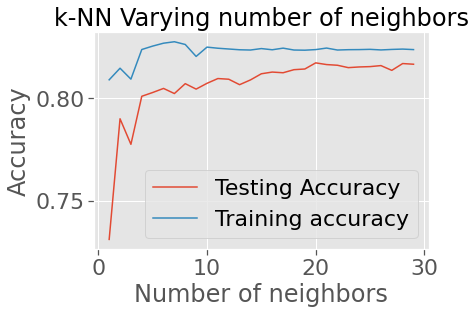

In [ ]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()


<font color='Green'><left><b>
We assume that after nuber of 10, there is just slight improvement.
</b></left>

In [ ]:
# Define the cross-validation approach
n_cv_knn = 5

# Define the maximum number of iterations
n_max_iter = 2000

# Create an instance of the class KNeighborsClassifier
knn_model = KNeighborsClassifier()

# Define the search space for the hyperparameters
search_space = dict()
search_space['n_neighbors'] = [10]
search_space['metric']      = ['euclidean', 'manhattan']

# Create an instance of the class GridSearchCV with desired characteristics
knn_grid_search_cv_scaled = GridSearchCV(estimator=knn_model, 
                                         param_grid=search_space, 
                                         scoring='recall', 
                                         cv=n_cv_knn, 
                                         n_jobs=-1)

# Run the search algorithm and summarize resuts 
knn_grid_search_cv_scaled.fit(X_scaled_train_second_reduced, y_train_second)

print(f'Best score: {knn_grid_search_cv_scaled.best_score_:.4f}')
print('Best hyperparameters: %s' % knn_grid_search_cv_scaled.best_params_)

Best score: 0.3129
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 10}


In [ ]:
# Create an instance of the class LinearSVC with specific selection of hyperparameters
knn_ccd_scaled = KNeighborsClassifier(n_neighbors=knn_grid_search_cv_scaled.best_params_['n_neighbors'], 
                                      metric=knn_grid_search_cv_scaled.best_params_['metric'])

# Fit the model
knn_ccd_scaled.fit(X_scaled_train_second_reduced, y_train_second)

# Predict outcomes in the training subsample and calculate recall
y_knn_pred_train = knn_ccd_scaled.predict(X_scaled_train_second_reduced)

# Predict outcomes in the testing subsample and calculate recall
y_knn_pred_test = knn_ccd_scaled.predict(X_scaled_test_second_reduced)

<font color='Green'><left><b>
Decision Tree
</b></left>

In [ ]:
# Define the cross-validation approach
n_cv_dt = 5

# Create an instance of the class DecisionTreeClassifier
dt_model = DecisionTreeClassifier()

# Define the search space for the hyperparameters
search_space = dict()
search_space['max_depth']        = [2, 3, 4, 5, 6, 7]
search_space['max_features']     = [2, 3, 4, 5, 6, 7]
search_space['min_samples_leaf'] = [2, 3, 4, 5, 6, 7]
search_space['criterion']        = ['gini', 'entropy']

# Create an instance of the class RandomizedSearchCV with desired characteristics
dt_randomized_search_cv_scaled = RandomizedSearchCV(estimator=dt_model, 
                                                    param_distributions=search_space, 
                                                    scoring='recall', 
                                                    cv=n_cv_dt, 
                                                    n_jobs=-1)

# Run the search algorithm and summarize resuts 
dt_randomized_search_cv_scaled.fit(X_scaled_train_second_reduced, y_train_second)

print(f'Best score: {dt_randomized_search_cv_scaled.best_score_:.4f}')
print('Best hyperparameters: %s' % dt_randomized_search_cv_scaled.best_params_)

Best score: 0.3750
Best hyperparameters: {'min_samples_leaf': 7, 'max_features': 5, 'max_depth': 7, 'criterion': 'gini'}


In [ ]:
# Create an instance of the class DecisionTreeClassifier with specific selection of hyperparameters
dt_ccd_scaled = DecisionTreeClassifier(max_depth=dt_randomized_search_cv_scaled.best_params_['max_depth'], 
                                       max_features=dt_randomized_search_cv_scaled.best_params_['max_features'], 
                                       min_samples_leaf=dt_randomized_search_cv_scaled.best_params_['min_samples_leaf'],
                                       criterion=dt_randomized_search_cv_scaled.best_params_['criterion'])

# Fit the model
dt_ccd_scaled.fit(X_scaled_train_second_reduced, y_train_second)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_dt_pred_train = dt_ccd_scaled.predict(X_scaled_train_second_reduced)

y_dt_pred_test = dt_ccd_scaled.predict(X_scaled_test_second_reduced)

<font color='Green'><left><b>
Random Forest
</b></left>

In [ ]:
# Define the cross-validation approach
n_cv_rf = 5

# Create an instance of the class RandomForestClassifier
rf_model = RandomForestClassifier()

# Define the search space for the hyperparameters
search_space = dict()
search_space['n_estimators']     = [50, 100, 150, 200, 250]
search_space['max_depth']        = [2, 3, 4, 5, 6, 7]
search_space['max_features']     = [2, 3, 4, 5, 6, 7]
search_space['min_samples_leaf'] = [2, 3, 4, 5, 6, 7]
search_space['criterion']        = ['gini', 'entropy']

# Create an instance of the class RandomizedSearchCV with desired characteristics
rf_randomized_search_cv_scaled = RandomizedSearchCV(estimator=rf_model, 
                                                    param_distributions=search_space, 
                                                    scoring='recall', 
                                                    cv=n_cv_rf, 
                                                    n_jobs=-1)

# Run the search algorithm and summarize resuts 
rf_randomized_search_cv_scaled.fit(X_scaled_train_second_reduced, y_train_second)

print(f'Best score: {rf_randomized_search_cv_scaled.best_score_:.4f}')
print('Best hyperparameters: %s' % rf_randomized_search_cv_scaled.best_params_)

Best score: 0.3626
Best hyperparameters: {'n_estimators': 150, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 7, 'criterion': 'entropy'}


In [ ]:
# Create an instance of the class RandomForestClassifier with specific selection of hyperparameters
rf_ccd_scaled = RandomForestClassifier(n_estimators=rf_randomized_search_cv_scaled.best_params_['n_estimators'], 
                                       max_depth=rf_randomized_search_cv_scaled.best_params_['max_depth'], 
                                       max_features=rf_randomized_search_cv_scaled.best_params_['max_features'], 
                                       min_samples_leaf=rf_randomized_search_cv_scaled.best_params_['min_samples_leaf'],
                                       criterion=rf_randomized_search_cv_scaled.best_params_['criterion'])

# Fit the model
rf_ccd_scaled.fit(X_scaled_train_second_reduced, y_train_second)

# Predict outcomes in the training and testing subsamples and calculate accuracy
y_rf_pred_train = rf_ccd_scaled.predict(X_scaled_train_second_reduced)

y_rf_pred_test = rf_ccd_scaled.predict(X_scaled_test_second_reduced)

In [ ]:
print('Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after')
print()
print()
print(100*'-')
print('Logistic regression with ROC treshold 0.230')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_pred_train_proba_second_rc):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_pred_test_proba_second_rc):.4f}')
print(100*'-')
print('Linear SVC')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_lsvc_pred_train):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_lsvc_pred_test):.4f}')
print(100*'-')
print('KNN')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_knn_pred_train):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_knn_pred_test):.4f}')
print(100*'-')
print('Decision Tree')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_dt_pred_train):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_dt_pred_test):.4f}')
print(100*'-')
print('Random Forest')
print(100*'-')
print(f'Recall score (train): {metrics.recall_score(y_train_second,y_rf_pred_train):.4f}')
print(100*'-')
print(f'Recall score (test): {metrics.recall_score(y_test_second,y_rf_pred_test):.4f}')
print(100*'-')


Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after


----------------------------------------------------------------------------------------------------
Logistic regression with ROC treshold 0.230
----------------------------------------------------------------------------------------------------
Recall score (train): 0.6014
----------------------------------------------------------------------------------------------------
Recall score (test): 0.6066
----------------------------------------------------------------------------------------------------
Linear SVC
----------------------------------------------------------------------------------------------------
Recall score (train): 0.4700
----------------------------------------------------------------------------------------------------
Recall score (test): 0.4537
----------------------------------------------------------------------------------------------------
KNN
---------------------------------

In [ ]:
print('Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after')
print()
print()
print(100*'-')
print('Logistic regression with threshold with ROC treshold 0.230')
print(100*'-')
print(confusion_matrix(y_train_second,y_pred_train_proba_second_rc))
print(100*'-')
print(confusion_matrix(y_test_second,y_pred_test_proba_second_rc))
print(100*'-')
print('Linear SVC')
print(100*'-')
print(confusion_matrix(y_train_second,y_lsvc_pred_train))
print(100*'-')
print(confusion_matrix(y_test_second,y_lsvc_pred_test))
print(100*'-')
print('KNN')
print(100*'-')
print(confusion_matrix(y_train_second,y_knn_pred_train))
print(100*'-')
print(confusion_matrix(y_test_second,y_knn_pred_test))
print(100*'-')
print('Decision Tree')
print(100*'-')
print(confusion_matrix(y_train_second,y_dt_pred_train))
print(100*'-')
print(confusion_matrix(y_test_second,y_dt_pred_test))
print(100*'-')
print('Random Forest')
print(100*'-')
print(confusion_matrix(y_train_second,y_rf_pred_train))
print(100*'-')
print(confusion_matrix(y_test_second,y_rf_pred_test))
print(100*'-')


Using PCA for feature reduction for PAY, PAY_AMT,BILL_AMT and standard scaling after


----------------------------------------------------------------------------------------------------
Logistic regression with threshold with ROC treshold 0.230
----------------------------------------------------------------------------------------------------
[[14371  4273]
 [ 2116  3193]]
----------------------------------------------------------------------------------------------------
[[3362 1311]
 [ 522  805]]
----------------------------------------------------------------------------------------------------
Linear SVC
----------------------------------------------------------------------------------------------------
[[16690  1954]
 [ 2814  2495]]
----------------------------------------------------------------------------------------------------
[[4156  517]
 [ 725  602]]
----------------------------------------------------------------------------------------------------
KNN
----------------

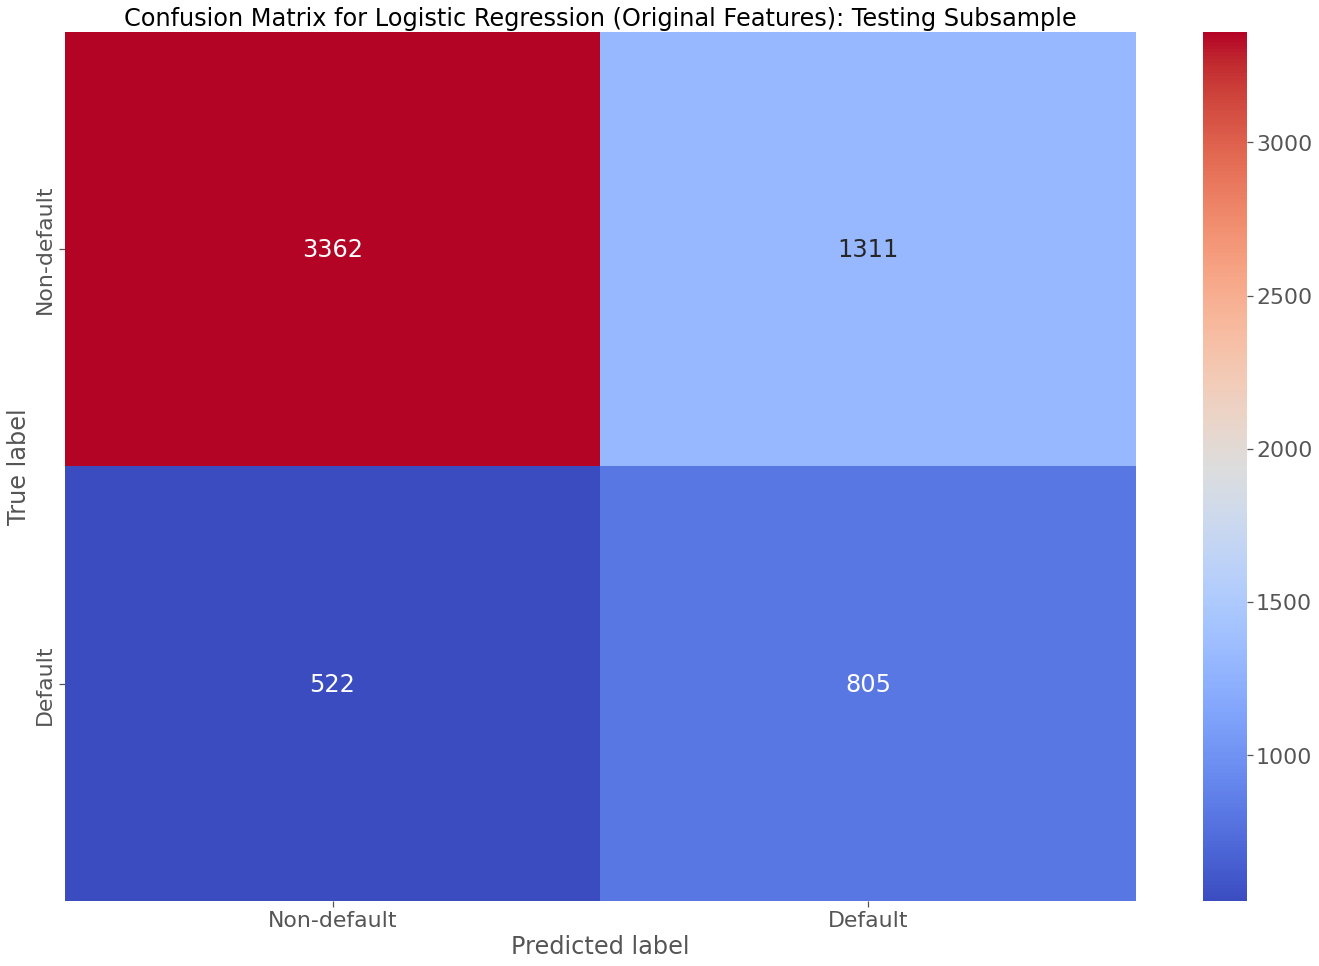

In [ ]:
plt.figure(figsize=(24,16))
logit_ccd_confusion_test = confusion_matrix(y_test_second,y_pred_test_proba_second_rc)
sns.heatmap(logit_ccd_confusion_test, annot=True, annot_kws={'size':24}, cmap='coolwarm', fmt='d', 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label', size=24)
plt.xlabel('Predicted label', size=24)
plt.title('Confusion Matrix for Logistic Regression (Original Features): Testing Subsample', size=24)
plt.show()

<font color='Green'><left><b>
We got surprizing result, as best recall has Logistic regression with ROC treshold 0.230.  
Even though other algorithams are better in reducing false predictions ( false positive + false negative ), LR is the best in minimizing False negatives, which was our goal since this is the direct loss for the bank ( We asume the recovery to be 0 in this case ). The oportunity loss ( false positive - not given credit card ) is smaller ( interest rate on credit card debt is probably around 20% ), than the direct loss ( default ).
</b></left>

# 3   Clustering

Consider again the Credit Card Default Dataset. The goal of this exercise to to apply
various clustering techniques on two selected features from this dataset (e.g., BILL AMT1
and PAY 0).


(a) <b>Data preprocessing:</b> Apply necessary filtering and transformations for the selected
features as part of the data prepossessing step.

Hint: Consider transformations that can result in symmetric distributions of features
(as well as removing strong outliers or observations which make such transformations
infeasible).


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import (KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN)
from sklearn.metrics import silhouette_samples
# Import / install relevant Python packages
import numpy as np
from numpy import (where, unique)
import pandas as pd
from pandas import set_option
import datetime as dt
import statsmodels.api as sm
from scipy.stats import (randint, loguniform, multivariate_normal)

from collections import Counter

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, cross_val_score)

from sklearn.datasets import (make_blobs, make_classification)
from sklearn.metrics import silhouette_samples
from sklearn.cluster import (KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN)
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import (linkage, dendrogram, set_link_color_palette)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use('ggplot')
import seaborn as sns

<font color='Green'><left><b>
We chose two features:  
limit balance and Pay_3 amount
</b></left>

In [ ]:
df_ccd=pd.read_csv('UCI_Credit_Card.csv') #importing the df


In [ ]:
# lets display the distribution of the limit balance

fig=go.Figure()
fig.add_trace(go.Histogram(x=df_ccd['LIMIT_BAL']))

<font color='Green'><left><b>
We see the right asymmetry in our data. So we will first try the square root transformation which is typical when the data have right asymmetry.
</b></left>

In [ ]:

fig=go.Figure()
fig.add_trace(go.Histogram(x=np.sqrt(df_ccd['LIMIT_BAL'])))

<font color='Green'><left><b>
This is a massive improvement. Now we will trim out values lower than 130 and greater than 750 in order to achive symetry.
</b></left>

In [ ]:
df=pd.DataFrame(np.sqrt(df_ccd['LIMIT_BAL']))
df['Pay_3']=df_ccd['PAY_3']

df.drop(index=df[(df['LIMIT_BAL']>750)|(df['LIMIT_BAL']<130)].index,inplace=True)

In [ ]:

fig=go.Figure()
fig.add_trace(go.Histogram(x=df['LIMIT_BAL']))

<font color='Green'><left><b>
For the other feature we will drop the payments with 1 month delay since there are only 4 observations, and we will with 3 denote payments that are three month late or more. 
</b></left>

In [ ]:
df['Pay_3'].groupby(df['Pay_3']).count()

Pay_3
-2     4040
-1     5858
 0    15416
 1        4
 2     3710
 3      216
 4       73
 5       20
 6       22
 7       23
 8        3
Name: Pay_3, dtype: int64

In [ ]:
df.drop(index=df[df['Pay_3']==1].index,inplace=True) #dropping the variable 1
df['Pay_3']=np.where(df['Pay_3']>3, 3, df['Pay_3']) # gropung payments that are late more than 3 months

(b) <b>Clustering algorithms:</b> Run the algorithms discussed in the lecture: K-means,
Gaussian mixture model, hierarchical agglomerative clustering, and DBSCAN.

– For each algorithm, try to replicate the analysis provided in the lecture notebook
(up to adjustments which might be necessary given the specific characteristics of
the Credit Card Default dataset).

– Discuss your modeling choices and findings.

<font color='Green'><left><b>
HIERACHICAL CLUSTERING 
</b></left>

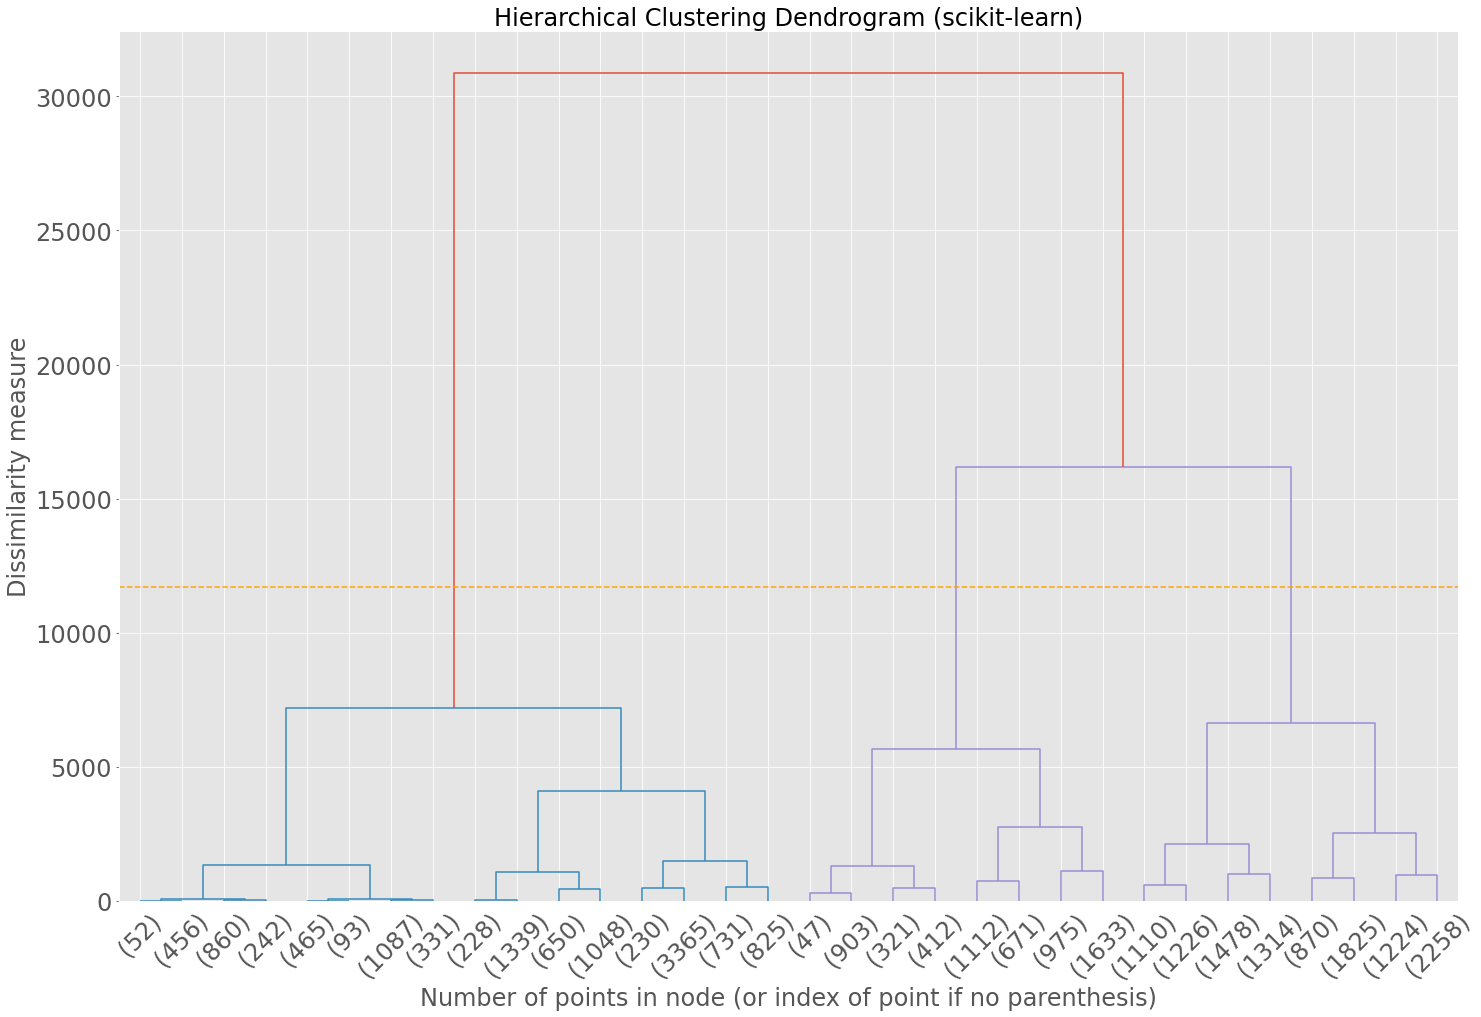

In [ ]:
# Define the key inputs for the AgglomerativeClustering model
distance_threshold = 0
n_clusters         = 3
linkage_type       = 'ward' 

# Create an instance of the class AgglomerativeClustering and fit the model
hca_model = AgglomerativeClustering(linkage=linkage_type, 
                                    distance_threshold=distance_threshold, 
                                    n_clusters=None)
hca_model.fit(df)

# Prepare inputs for the linkage matrix
counts = np.zeros(hca_model.children_.shape[0])
n_samples = len(hca_model.labels_)

for i, children in enumerate(hca_model.children_):
    current_count = 0
    for ix_child in children:
        if ix_child < n_samples:
            current_count += 1  
        else:
            current_count += counts[ix_child - n_samples]
    counts[i] = current_count

# Compute the linkage matrix    
linkage_matrix = np.column_stack([hca_model.children_, hca_model.distances_, counts]).astype(float)

# Calculate the distance threshold (cut-off level) given the number of clusters
distances_sorted = np.sort(linkage_matrix[:,2])
distances_sorted = distances_sorted[::-1]
n_color_threshold  = 0.5 * (distances_sorted[n_clusters-2] + distances_sorted[n_clusters-1])

# Specify the color palette
#set_link_color_palette(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])

# Create a dendogram plot (and add the threshold line)
plt.figure(figsize=(24,16))
dendrogram(linkage_matrix, truncate_mode='level', p=4)
#dendrogram(linkage_matrix, truncate_mode='level', p=4, color_threshold=n_color_threshold, above_threshold_color='k')
plt.axhline(n_color_threshold, color='orange', linestyle='--')
plt.title('Hierarchical Clustering Dendrogram (scikit-learn)', size=24)
plt.xlabel('Number of points in node (or index of point if no parenthesis)', size=24)
plt.ylabel('Dissimilarity measure', size=24)
plt.xticks(size=24) 
plt.yticks(size=24)   
plt.show()

# Reset the color palette to the default values
set_link_color_palette(None)

<font color='Green'><left><b>
We chose to use dendogram in order to determinate the optimal number of clusters with ward measures. The biggest distance among the dissimilarity measures is between the blue and purple line (less than 10k up to 15k), so there we have drawn a yellow line, where this distance based on the dissimilarity meassure is maximal, resulting in the optimal number of clusters to be three.
</b></left>

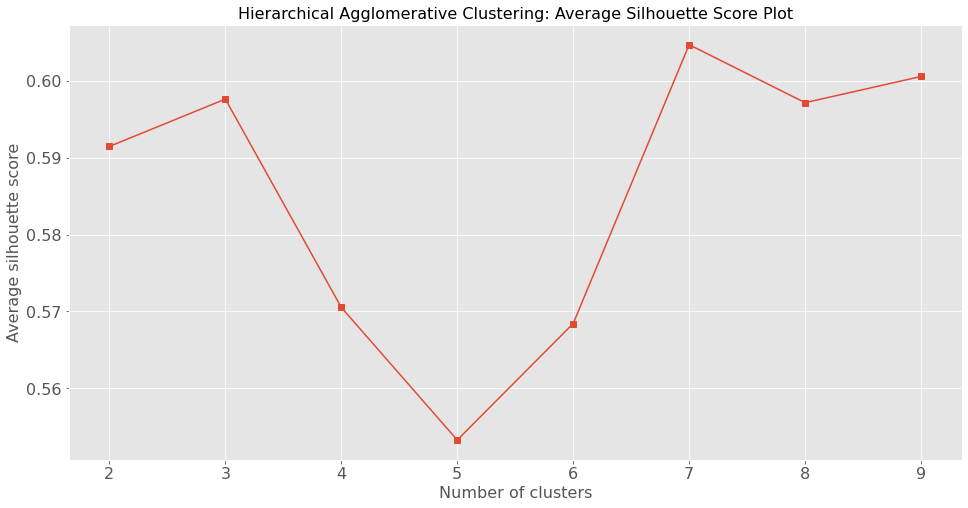

In [ ]:
# Define the bounds for the number of clusters
n_clusters_lb = 2
n_clusters_ub = 10

# Initiate the average silhouette score vector 
hca_silhouette_avg = []

# Fit AgglomerativeClustering model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    hca_model = AgglomerativeClustering(n_clusters=ix_clusters,
                                        linkage='ward')
    y_pred = hca_model.fit_predict(df)
    silhouette_vals = silhouette_samples(df, y_pred, metric='euclidean')
    hca_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), hca_silhouette_avg, marker='s')
plt.title('Hierarchical Agglomerative Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

<font color='Green'><left><b>
Due to the re-running of the algorithm the Silluoette plot changeed its apperance. However, Still 3 clusters has simmilar score to the 7 clusters, so we opt in this case for 3 clusters due to the simpler interpretation.
</b></left>

In [ ]:
hc = AgglomerativeClustering(n_clusters = 3,linkage ='ward')

y_hc = hc.fit_predict(df)
#t(df)
y_hc

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# Cluster apperance

import plotly.express as px
df['cluster_chierachy']=y_hc
fig = px.scatter(df, y="LIMIT_BAL", x="Pay_3", color="cluster_chierachy")
fig.show()

In [ ]:
df.groupby('cluster_chierachy').mean()

,LIMIT_BAL,Pay_3
cluster_chierachy,,
0,226.783387,0.214464
1,422.213841,-0.371517
2,604.436484,-0.629075


In [ ]:
fig=go.Figure()
fig.add_trace(go.Bar(x=[1,2,3],y=[i[1] for i in df.groupby('cluster_chierachy').mean().values]))


In [ ]:
fig=go.Figure()
fig.add_trace(go.Bar(x=[1,2,3],y=[i[0] for i in df.groupby('cluster_chierachy').mean().values]))


<font color='Green'><left><b>
Clusters descriptions:  
cluster 0: customers with highest Pay_3 score, which means that they don't service it on time (higher Pay_3 means greater delay), so they have consequently the lowest limit balance amount;  
cluster 1: customers with medium Pay_3 score and medium limit balance;  
cluster 2: customers which service their obligations relatively on time (highest pay 3 score the closest to -1) and consequntly it is the cluster, which gets the highest limit balance.
</b></left>


In [ ]:
#Gaussian mixture models 

In [ ]:
df.drop('cluster_chierachy',axis=1,inplace=True)

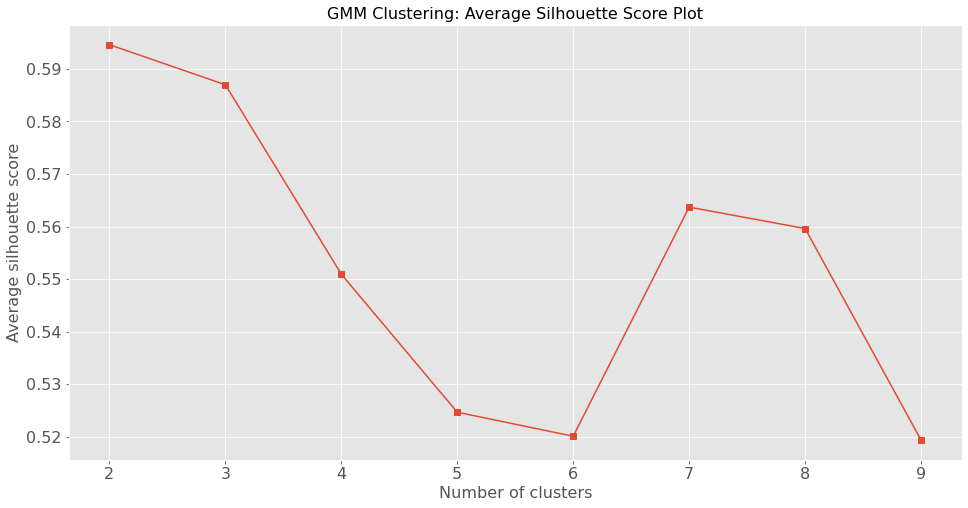

In [ ]:
#Gaussian mixture models

# Define the bounds for the number of clusters
n_clusters_lb = 2
n_clusters_ub = 10

# Initiate the average silhouette score vector 
gmm_silhouette_avg = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    gmm_model = GaussianMixture(n_components=ix_clusters,
                                n_init=10,
                                random_state=1)
    y_pred = gmm_model.fit_predict(df)
    silhouette_vals = silhouette_samples(df, y_pred, metric='euclidean')
    gmm_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), gmm_silhouette_avg, marker='s')
plt.title('GMM Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

<font color='Green'><left><b>
The higherst silhouette score is three. We will employ Information Criteria, to be sure in regard with the final decision.
</b></left>

Best AIC score: 393336.76
Optimal number of clusters: 7
----------------------------------------------------------------------------------------------------
Best BIC score: 393676.57
Optimal number of clusters: 7
----------------------------------------------------------------------------------------------------


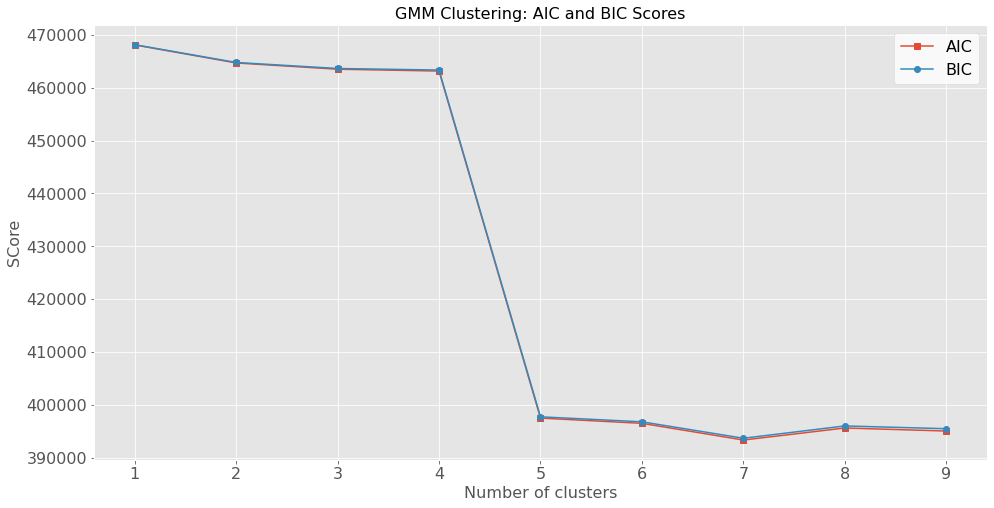

In [ ]:
# Define the bounds for the number of clusters
n_clusters_lb = 1
n_clusters_ub = 10

# Initiate the vectors of AIC and BIC scores
gmm_aic = []
gmm_bic = []

# Fit GMM model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    gmm_model = GaussianMixture(n_components=ix_clusters,
                                n_init=10,
                                random_state=1)
    gmm_model.fit(df)
    
    gmm_aic.append(gmm_model.aic(df))
    gmm_bic.append(gmm_model.bic(df))

# Display the key information       
print(f'Best AIC score: {round(min(gmm_aic),2)}')
print(f'Optimal number of clusters: {gmm_aic.index(min(gmm_aic))+1}') 
print(100*'-')
print(f'Best BIC score: {round(min(gmm_bic),2)}')
print(f'Optimal number of clusters: {gmm_bic.index(min(gmm_bic))+1}') 
print(100*'-')
    
# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), gmm_aic, marker='s', label='AIC')
plt.plot(range(n_clusters_lb,n_clusters_ub), gmm_bic, marker='o', label='BIC')
plt.legend(fontsize=16, facecolor='white')
plt.title('GMM Clustering: AIC and BIC Scores', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('SCore', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

<font color='Green'><left><b>
As we aim for the minimum number of clusters, we will try with 5 clusters, since the AIC and BIC are very close for 5 and 7 clusters.
</b></left>

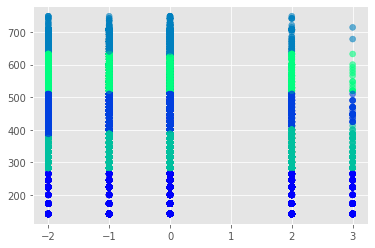

In [ ]:
# Visualizing the clustering 
plt.scatter(df['Pay_3'], df['LIMIT_BAL'],  
           c = GaussianMixture(n_components = 5).fit_predict(df), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

In [ ]:
#describing clusters
desc_clust=pd.DataFrame(GaussianMixture(n_components = 5).fit_predict(df))
desc_clust['Pay_3']=df['Pay_3']
desc_clust['Limit_bal']=df['LIMIT_BAL']

In [ ]:
fig=go.Figure()

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).index],y=desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),3),name='cluster 0'))
fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).count().iloc[5:10].apply(lambda x:x/sum(x)).index],y=desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).count().iloc[5:10].apply(lambda x:x/sum(x)).values.flatten(),3),name='cluster 1'))
fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).count().iloc[10:15].apply(lambda x:x/sum(x)).index],y=desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).count().iloc[10:15].apply(lambda x:x/sum(x)).values.flatten(),3),name='cluster 2'))
fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).count().iloc[15:20].apply(lambda x:x/sum(x)).index],y=desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).count().iloc[15:20].apply(lambda x:x/sum(x)).values.flatten(),3),name='cluster 3'))
fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).count().iloc[20:25].apply(lambda x:x/sum(x)).index],y=desc_clust.groupby([0,'Pay_3']).count().iloc[0:5].apply(lambda x:x/sum(x)).values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).count().iloc[20:25].apply(lambda x:x/sum(x)).values.flatten(),3),name='cluster 4'))
 

In [ ]:
fig=go.Figure()

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).mean().iloc[0:5].index],y=desc_clust.groupby([0,'Pay_3']).mean().iloc[0:5].values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).mean().iloc[0:5].values.flatten(),3)))

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).mean().iloc[5:10].index],y=desc_clust.groupby([0,'Pay_3']).mean().iloc[5:10].values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).mean().iloc[5:10].values.flatten(),3)))

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).mean().iloc[10:15].index],y=desc_clust.groupby([0,'Pay_3']).mean().iloc[10:15].values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).mean().iloc[10:15].values.flatten(),3)))

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).mean().iloc[15:20].index],y=desc_clust.groupby([0,'Pay_3']).mean().iloc[15:20].values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).mean().iloc[15:20].values.flatten(),3)))

fig.add_trace(go.Bar(x=[i[1] for i in desc_clust.groupby([0,'Pay_3']).mean().iloc[20:25].index],y=desc_clust.groupby([0,'Pay_3']).mean().iloc[20:25].values.flatten(),text=np.round(desc_clust.groupby([0,'Pay_3']).mean().iloc[20:25].values.flatten(),3)))


<font color='Green'><left><b>
Cluster 1 gives the lowest allowance for people who are late 3 or more months.
</b></left>


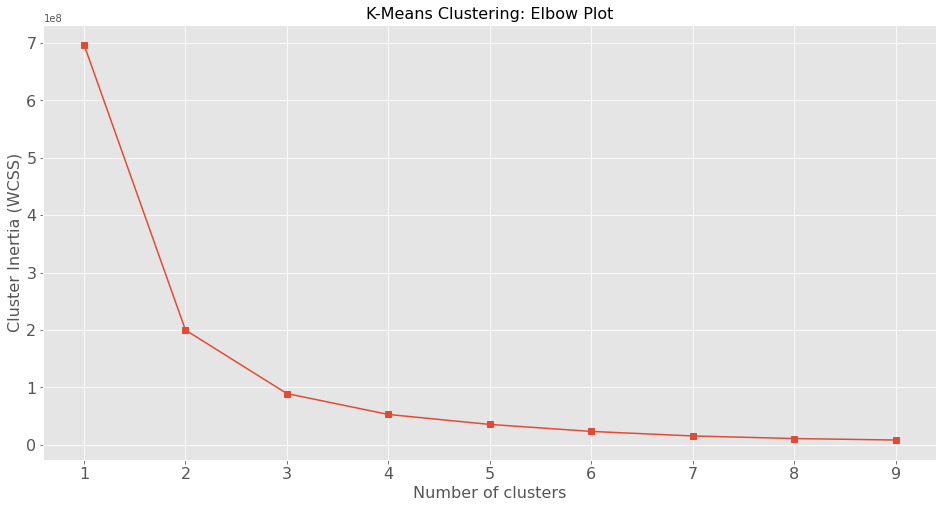

In [ ]:
#kmeans

# Define the bounds for the number of clusters
n_clusters_lb = 1
n_clusters_ub = 10

# Initiate the cluster inertia (WCSS) vector 
kmeans_interia = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    kmeans_model = KMeans(n_clusters=ix_clusters,
                          init='k-means++',
                          n_init=10,
                          max_iter=1000,
                          random_state=1)
    kmeans_model.fit(df)
    kmeans_interia.append(kmeans_model.inertia_)

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), kmeans_interia, marker='s')
plt.title('K-Means Clustering: Elbow Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Cluster Inertia (WCSS)', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

<font color='Green'><left><b>
Based on the elbow method we conclude that optimal number of clusters is 3.  
But as an alternative, one can use silhouette score.
</b></left>

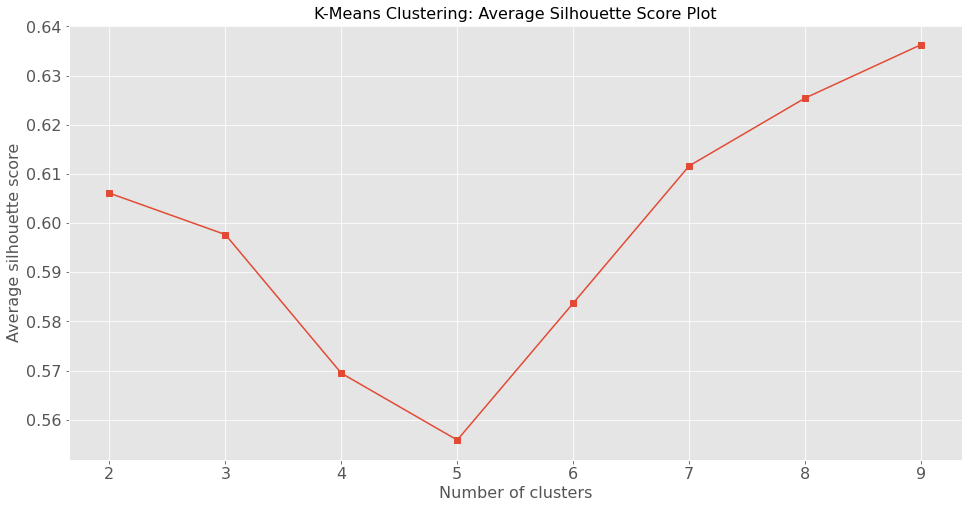

In [ ]:
# Define the bounds for the number of clusters
n_clusters_lb = 2
n_clusters_ub = 10

# Initiate the average silhouette score vector 
kmeans_silhouette_avg = []

# Fit K-means model for different numbers of clusters
for ix_clusters in range(n_clusters_lb, n_clusters_ub):
    kmeans_model = KMeans(n_clusters=ix_clusters,
                          init='k-means++',
                          n_init=10,
                          max_iter=1000,
                          random_state=1)
    y_pred = kmeans_model.fit_predict(df)
    silhouette_vals = silhouette_samples(df, y_pred, metric='euclidean')
    kmeans_silhouette_avg.append(np.mean(silhouette_vals))

# Create the elbow plot
plt.figure(figsize=(16,8))    
plt.plot(range(n_clusters_lb,n_clusters_ub), kmeans_silhouette_avg, marker='s')
plt.title('K-Means Clustering: Average Silhouette Score Plot', size=16)
plt.xlabel('Number of clusters', size=16)
plt.ylabel('Average silhouette score', size=16)
plt.xticks(size=16) 
plt.yticks(size=16)  
plt.show()

<font color='Green'><left><b>
3 clusters have a very high score.
</b></left>

In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df)

df['cluster_knn']=y_kmeans

In [ ]:
[i[1] for i in df.groupby('cluster_knn').mean().values]


[0.21446425595734045, -0.6290747448139612, -0.3715170278637771]

In [ ]:
fig=go.Figure()
fig.add_trace(go.Bar(x=[1,2,3],y=[i[1] for i in df.groupby('cluster_knn').mean().values]))


In [ ]:
fig=go.Figure()
fig.add_trace(go.Bar(x=[1,2,3],y=[i[0] for i in df.groupby('cluster_knn').mean().values]))

<font color='Green'><left><b>
Cluster 1: Consumers which don't meet their obligations on time (highest pay_3 score) and consequently get the lowest limit balance;  
Cluster 3 Consumers with slight delay in payments and middle limit balance;  
Cluster 2 Consumers who pay their duties on time and consequntly get highest limit balance 
</b></left>


In [ ]:
df


,LIMIT_BAL,Pay_3,cluster_knn
0,141.421356,-1,0
1,346.410162,0,2
2,300.000000,0,0
3,223.606798,0,0
4,223.606798,-1,0
...,...,...,...
29995,469.041576,0,2
29996,387.298335,-1,2
29997,173.205081,2,0
29998,282.842712,0,0


In [ ]:
df.drop('cluster_knn',axis=1,inplace=True)

In [ ]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(df)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(df, DBS_clustering.labels_))

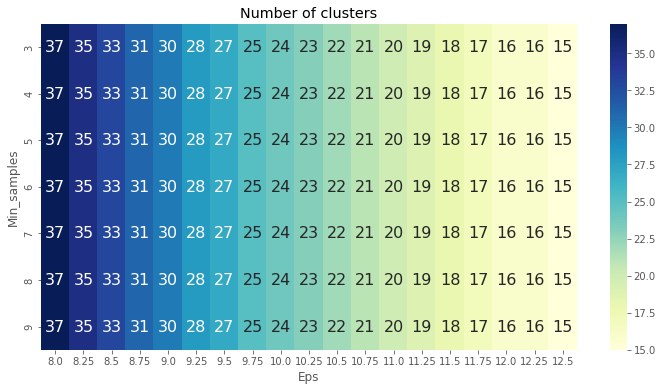

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

<font color='Green'><left><b>
Heatmap shows the number of clusters to range from 37 to 15, while majority falls from 15 to 25, which is a lot and we would lose interpretability.
</b></left>

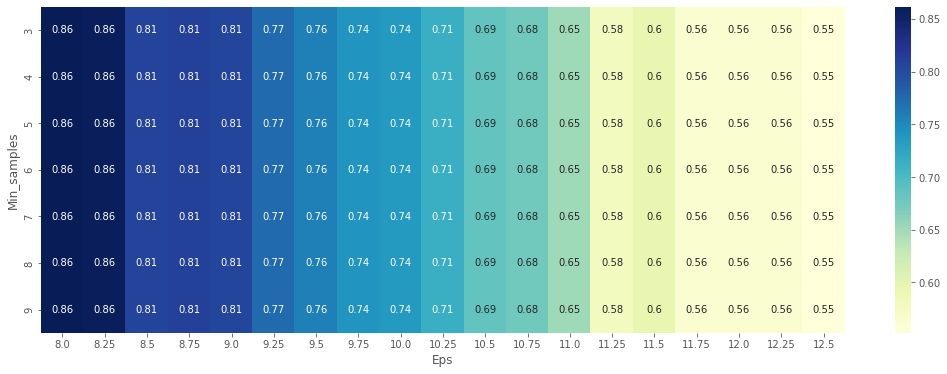

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [ ]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(df)

DBSCAN_clustered = df.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

<font color='Green'><left><b>
Checking sizes of clusters.
</b></left>

In [ ]:

DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
0,1976
1,726
2,650
3,3365
4,13477
5,1048
6,749
7,731
8,729


<font color='Green'><left><b>
DBSCAN created 15 clusters, whose sizes vary significantly - smallest has only 230 observations while largest has 13477 observations. There are no outliers.
</b></left>

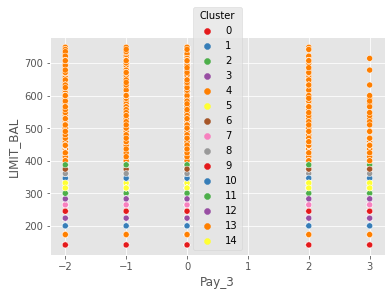

In [ ]:
sns.scatterplot('Pay_3', 'LIMIT_BAL',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', legend='full')

(c) <b>Clustering algorithms:</b> Try to consolidate (quantitatively or qualitatively) the results you
have obtained using different algorithms and come up with a final proposal regarding
the optimal number of clusters.

<font color='Green'><left><b>
Note on trasformations:  
Since Pay_3 is ordinary categorical variable, the grouping of variables (for scores higher than 3 is to denote them with 3) is intutive way of creating more symetrical data distribution. Furthermore, we can associate the higher possive scores with higher delay in payments and in a way we can assume the closer the score is to -1, the payments are more regular.  
For the interpretation of the square root of limit balance we don't face such problem: as the higher sqrt of limit balance is, the higher the limit balance is. This is due to the fact that sqrt is monotonically increasing function of x, provided that x is positive (which is true in our case)
</b></left>

<font color='Green'><left><b>
Generally, the optimal number of cluster in our case is 3:  
Customers who pay on time (Pay_3 closest to -1, with no delay) and get the highest limit balance;  
Customers who pay with slight delay (Pay_3 is negative, but lower than customers who pay on time) and get the middle limit balance;  
Customers with the delay in payments (possitive Pay_3) and who consequenly get the lowest limit balnce.
</b></left>